# Collecting Brazil's 2022 presidential election polls data
> A tutorial on how to collect, filter and prepare for analysis Brazil's 2022 presidential election polls data.

- toc: true 
- badges: true
- comments: true
- categories: [data-science]
- hide: false
- search_exclude: false
- image: images/chart-preview.png

## Context

This year [more than 146 million fellow Brazilian](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo) are going to choose our new President...

## Data sources

### Pool data
- [Poder360 polls database](https://www.poder360.com.br/banco-de-dados/)
### Voters statistics

- [TSE: Voters statistics by Region](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo)
- [TSE: Voters statistics by sex and age](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/estatistica-do-eleitorado-por-sexo-e-faixa-etaria)

### Dashboard
- [App](https://chance-lula-ganhar-1o-turno.github.io/)
- [Repositório: Chance de Lula ganhar no primeiro turno](https://github.com/chance-lula-ganhar-1o-turno)
  

## Analysis

### Importing libraries

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and transform data

In [2]:
#noshow 
columns_to_use = ["pesquisa_id", "cenario_id", "turno", "partido",
                  "candidato", "cenario_descricao", "instituto",
                  "percentual", "data_pesquisa", "qtd_entrevistas",
                  "qtd_mencoes","grupo"]

HDI = [0.025, 0.5, 0.975] # quantiles

In [3]:
def enrich_and_filter(df: pd.DataFrame) ->pd.DataFrame:
    df['qtd_mencoes'] = df.percentual * df.qtd_entrevistas / 100.0
    df['grupo'] = 'OUTROS'
    df.loc[(df.partido == 'PT'), 'grupo'] = 'LULA'
    df.loc[(df.partido.isna()), 'grupo'] = 'NULO'

    return df[columns_to_use]

In [4]:
def get_most_recent_file() -> Path:
    data_dir = Path('../assets/data/elections2022/')
    return sorted(data_dir.glob('2022*.csv'))[-1]
print(get_most_recent_file())

../assets/data/elections2022/20220211.csv


In [5]:
def get_most_recent_df() -> pd.DataFrame:
    return enrich_and_filter(pd.read_csv(get_most_recent_file(),
                                         sep=',',
                                         parse_dates=True,
                                         dayfirst=True)
                             )


In [6]:
raw_df = get_most_recent_df()
raw_df.head()

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_pesquisa,qtd_entrevistas,qtd_mencoes,grupo
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,2021-11-04,2000,240.0,NULO
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,2021-11-04,2000,200.0,NULO
2,9750,24567,1,PSD,Rodrigo Pacheco,cenário 1 - estimulado - 1º turno,Vox Populi,0.0,2021-11-04,2000,0.0,OUTROS
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,2021-11-04,2000,880.0,LULA
4,9750,24567,1,sem partido,Bolsonaro,cenário 1 - estimulado - 1º turno,Vox Populi,21.0,2021-11-04,2000,420.0,OUTROS


In [7]:
def prepare_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    table_df = raw_df.pivot_table(values=['qtd_mencoes'],
                        index=['data_pesquisa', 'instituto'],
                        columns=['grupo'],
                        aggfunc=np.sum)
    table_df2 = table_df
    table2 = table_df.reset_index(col_level=1).copy()
    table2.columns = [a[1] for a in table2.columns.to_flat_index()]
    table2["TOTAL"] = table2['LULA'] + table2['NULO'] + table2['OUTROS']
    table2["mes"] = pd.to_datetime(table2['data_pesquisa']).dt.strftime('%Y_%m')
    # print(table2)
    # table3 = table2.groupby('data_pesquisa').agg({'LULA':'sum', 'NULO':'sum', 'OUTROS':'sum', 'TOTAL':'sum', 'mes':'first', 'instituto': 'first'})
    # table3 = table3.reset_index(col_level=1).copy()
    # print(table3.columns)
    # table3.columns = [a for a in table3.columns.to_flat_index()]
    
    return table2

In [8]:
df = prepare_df(raw_df)
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [9]:
def simulate_prob_freq(concentration: np.array, iters=10_000, N=100_000) -> float:
    priors = stats.dirichlet.rvs(concentration, iters)
    cnt = 0
    for i in range(iters):
        votes = stats.multinomial(n=100_000, p = priors[i]).rvs()[0]
        if votes[0] > votes[2]:
            cnt += 1
    return cnt/iters * 100
# simulate_prob_freq(np.array([723, 186, 780]))
#stats.multinomial(n=100_000, p = np.array([0.45, 0.11, 0.44])).rvs()

In [10]:
def run_prob_weekly(simulate_prob):
    prior = np.array([420,130,450])
    posterior = np.array([0,0,0])
    for obj in df.itertuples():
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior * 0.7 + like * 0.3
        print(obj.data_pesquisa, posterior/posterior.sum(), simulate_prob(posterior))
        prior = posterior

run_prob_weekly(simulate_prob_freq)

2021-11-04 [0.43122102 0.17233385 0.39644513] 91.28
2021-11-06 [0.45102118 0.15920902 0.38976979] 99.6
2021-11-19 [0.41407311 0.1500793  0.43584758] 15.989999999999998
2021-11-20 [0.39914407 0.12329248 0.47756345] 0.03
2021-11-24 [0.37827834 0.11116349 0.51055818] 0.0
2021-11-29 [0.40252051 0.07256674 0.52491276] 0.0
2021-12-05 [0.41653328 0.08413037 0.49933635] 0.0
2021-12-09 [0.40861154 0.09193913 0.49944932] 0.0
2021-12-11 [0.4142076  0.10956301 0.4762294 ] 0.2
2021-12-13 [0.40393608 0.10239696 0.49366696] 0.0
2021-12-13 [0.42632766 0.11346649 0.46020585] 5.37
2021-12-16 [0.44967803 0.10760784 0.44271413] 64.05
2021-12-16 [0.44762626 0.10924581 0.44312793] 59.35
2021-12-21 [0.42939263 0.10953455 0.46107282] 5.53
2022-01-09 [0.43723533 0.11293436 0.44983031] 26.32
2022-01-12 [0.4362757  0.11531045 0.44841384] 28.720000000000002
2022-01-13 [0.43065426 0.11424395 0.45510179] 13.87
2022-01-18 [0.42795808 0.11717407 0.45486785] 9.27
2022-01-21 [0.41121419 0.11430964 0.47447617] 0.12
2022

In [11]:
mes = df.groupby("mes").sum().reset_index()
mes

,mes,LULA,NULO,OUTROS,TOTAL
0,2021_11,6048.848,1507.332,7382.820,14939.0
1,2021_12,7356.516,1973.626,7586.858,16917.0
2,2022_01,4833.000,1369.000,5249.000,11451.0
3,2022_02,2940.020,708.060,3371.920,7020.0


3.0
[1. 1. 1.]
[1. 1. 1.]


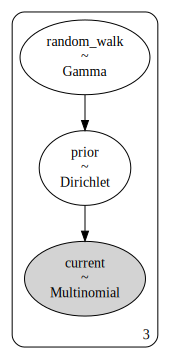

In [12]:
def build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0) -> pm.Model:
    N = observed.sum() if not np.all(np.isnan(observed)) else 1_000
    print(N)
    print(prior)
    print(observed)
    with pm.Model() as dirichlet_model:
        rw = pm.Gamma("random_walk",
                      alpha=(rw_alpha_mult * prior),
                      beta=(rw_beta_mult * np.ones(3)), shape=(3,)
                      )
        
        previous_month_prior = pm.Dirichlet(
            "prior", a=rw, shape=(3,),
        )

        pm.Multinomial(
            "current", n=N, p=(previous_month_prior), observed=observed, shape=(3,)
        )
    
    return dirichlet_model
model = build_model(np.ones(3), np.ones(3))
pm.model_to_graphviz(model)

In [13]:

def sampling(model: pm.Model, samples=2000, chains=2):
    with model:
        dirichlet_trace = pm.sample(samples, tune=2000, chains=chains, return_inferencedata=True, progressbar=False)
        ppc = pm.fast_sample_posterior_predictive(dirichlet_trace, 5000)
    return dirichlet_trace , ppc

def calc_prob_lula_win(model, trace, niter=30, ppc=None):
    simul = []
    if ppc:
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    for _ in tqdm(range(niter)):
        with model:
            ppc = pm.fast_sample_posterior_predictive(trace, 10000)
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    simul = np.array(simul)
    return np.quantile(simul, q=HDI)

## MONTHLY

In [14]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()
for obj in df_by_mes.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS]).astype("int32")
    rw_alpha_mult=1.0; rw_beta_mult=0.5
    print(f">>> observed = {observed}")
    model_m = build_model(prior, observed, rw_alpha_mult=rw_alpha_mult, rw_beta_mult=rw_beta_mult)
    trace_m, ppc_m = sampling(model_m)
    posterior_m = ppc_m['current']
    prior = dirichlet.mle(posterior_m/posterior_m.sum(axis=1).reshape(-1, 1))
    qs = calc_prob_lula_win(model_m, trace_m, 50, ppc=ppc_m)
    print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
    post_prob = posterior_m/posterior_m.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



>>> observed = [6048 1507 7382]
14937
[420. 130. 450.]
[6048 1507 7382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_11, updaed_prior=[3065.01253839  771.91357701 3720.43203572],  qs=['0.0%', '0.0%', '0.0%'] <<<
lula= [0.39478978 0.40563701 0.41675203]
nulo= [0.09553458 0.10216242 0.1089911 ]
demais= [0.48095334 0.49226752 0.50344781]
>>> observed = [7356 1973 7586]
16915
[3065.01253839  771.91357701 3720.43203572]
[7356 1973 7586]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_12, updaed_prior=[4039.9680076  1068.97435327 4327.20714907],  qs=['0.0425%', '0.09%', '0.1425%'] <<<
lula= [0.41797221 0.4281407  0.43789536]
nulo= [0.10688738 0.11321312 0.11965859]
demais= [0.44859444 0.45852793 0.4686979 ]
>>> observed = [4833 1369 5249]
11451
[4039.9680076  1068.97435327 4327.20714907]
[4833 1369 5249]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2022_01, updaed_prior=[2951.77828642  815.85131582 3188.37698136],  qs=['0.08%', '0.13%', '0.2%'] <<<
lula= [0.41271286 0.42432975 0.43585713]
nulo= [0.1098594  0.11728233 0.12479259]
demais= [0.44677321 0.45847524 0.47000262]
>>> observed = [2940  708 3371]
7019
[2951.77828642  815.85131582 3188.37698136]
[2940  708 3371]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2022_02, updaed_prior=[1855.09178315  472.46047542 2074.59036722],  qs=['0.0025%', '0.03%', '0.057499999999999996%'] <<<
lula= [0.40689557 0.42128508 0.43610557]
nulo= [0.09816213 0.10728024 0.11682576]
demais= [0.45647528 0.47136344 0.48568528]


model = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)


>>> mes=2021_12, updaed_prior=[4010.21159264 1063.82999647 4263.9625701 ],  qs=['0.1925%', '0.26%', '0.33999999999999997%'] <<<
lula= [0.4193896  0.42938221 0.43949305]
nulo= [0.10747857 0.11392255 0.1205439 ]
demais= [0.44670263 0.45651788 0.46668637]
>>> mes=2022_01, updaed_prior=[1986.94630475  542.79884705 2077.89947253],  qs=['7.24%', '7.6%', '8.0175%'] <<<
lula= [0.41708137 0.43120377 0.44559516]
nulo= [0.10867518 0.11782112 0.12723605]
demais= [0.43658373 0.45097512 0.46523201]

In [15]:
az.summary(trace_m)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],5873.496,97.538,5693.102,6056.103,1.778,1.258,3021.0,2253.0,1.0
random_walk[1],1538.047,44.036,1458.748,1622.601,0.826,0.584,2798.0,2741.0,1.0
random_walk[2],6496.812,102.843,6322.023,6704.854,1.852,1.309,3080.0,2169.0,1.0
prior[0],0.421,0.005,0.413,0.430,0.000,0.000,3180.0,2803.0,1.0
prior[1],0.107,0.003,0.102,0.112,0.000,0.000,2646.0,2805.0,1.0
prior[2],0.471,0.005,0.463,0.480,0.000,0.000,3789.0,3335.0,1.0


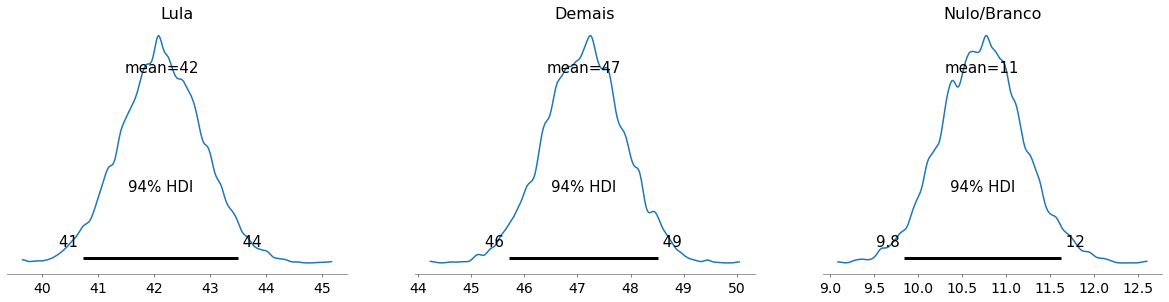

In [16]:
lula_m = ppc_m['current'][:,0] / ppc_m['current'].sum(axis=1) * 100.00
nulo_m = ppc_m['current'][:,1] / ppc_m['current'].sum(axis=1) * 100.00
demais_m = ppc_m['current'][:,2] / ppc_m['current'].sum(axis=1) * 100.00
post_pred = {'Lula': lula_m, 'Demais': demais_m, 'Nulo/Branco':nulo_m}
az.plot_posterior(post_pred);

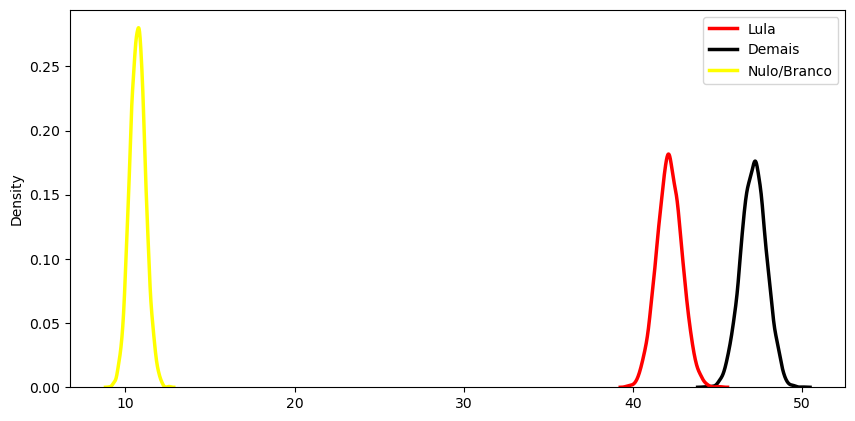

In [17]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','black','yellow'], linewidth=2.5, gridsize=500);

In [18]:
(post_pred['Lula'] > post_pred['Demais']).mean()

0.0006

### Weekly update

In [19]:
flat_prior = prior = np.array([400.0, 130.0, 470.0])

# df_by_mes = df.groupby("mes").sum().reset_index()
# for obj in df_by_mes.itertuples():
df_results_weekly = pd.DataFrame({})
# print(df)

for obj in df.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS]).astype("int32")
    print(f">>> observed = {observed}")
    
    model_w = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)
    #model_w = build_model(prior, observed, rw_alpha_mult=2, rw_beta_mult=1.0)
    trace_w, ppc_w = sampling(model_w)
    posterior_w = ppc_w['current']
    
    prior = dirichlet.mle(posterior_w/posterior_w.sum(axis=1).reshape(-1, 1))
    
    qs = calc_prob_lula_win(model_w, trace_w, ppc=ppc_w)
    
    print(f">>> data_pesquisa={obj.data_pesquisa}, updaed_prior={prior},  qs={qs}% <<<");
    post_prob = posterior_w/posterior_w.sum(axis=1).reshape(-1, 1)
    df_results_weekly = df_results_weekly.append(pd.DataFrame({"data":[obj.data_pesquisa],
                                           "LulaLB":[np.quantile(post_prob[:, 0], q=HDI)[0]],
                                           "LulaM":[np.quantile(post_prob[:, 0], q=HDI)[1]],
                                           "LulaUB":[np.quantile(post_prob[:, 0], q=HDI)[2]],
                                           "DemaisLB":[np.quantile(post_prob[:, 2], q=HDI)[0]],
                                           "DemaisM":[np.quantile(post_prob[:, 2], q=HDI)[1]],
                                           "DemaisUB":[np.quantile(post_prob[:, 2], q=HDI)[2]]}))
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
df_results_weekly

>>> observed = [880 440 660]
1980
[400. 130. 470.]
[880 440 660]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-04, updaed_prior=[610.19699698 235.06220075 624.52242392],  qs=[33.535 34.28  35.1  ]% <<<
lula= [0.38989899 0.41565657 0.43989899]
nulo= [0.14141414 0.15959596 0.17979798]
demais= [0.4        0.42525253 0.45001263]
>>> observed = [990 288 783]
2061
[610.19699698 235.06220075 624.52242392]
[990 288 783]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-06, updaed_prior=[709.35363074 254.77381011 679.14280768],  qs=[78.435 79.06  79.78 ]% <<<
lula= [0.40756914 0.43134401 0.45560408]
nulo= [0.13731198 0.15526443 0.17224648]
demais= [0.39008976 0.41290636 0.43765163]
>>> observed = [ 704  270 1044]
2018
[709.35363074 254.77381011 679.14280768]
[ 704  270 1044]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-19, updaed_prior=[656.60161233 239.5281643  698.17284125],  qs=[12.34   12.77   13.1725]% <<<
lula= [0.38800793 0.41179386 0.43658325]
nulo= [0.13280476 0.1506442  0.16750496]
demais= [0.41328048 0.43805748 0.46233895]
>>> observed = [ 740  142 1118]
2000
[656.60161233 239.5281643  698.17284125]
[ 740  142 1118]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-20, updaed_prior=[653.23368102 213.10576282 757.96616478],  qs=[0.185  0.26   0.3225]% <<<
lula= [0.378 0.402 0.427]
nulo= [0.1155 0.131  0.148 ]
demais= [0.443  0.4665 0.491 ]
>>> observed = [ 850  225 1400]
2475
[653.23368102 213.10576282 757.96616478]
[ 850  225 1400]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-24, updaed_prior=[737.33152449 228.7594866  943.4297913 ],  qs=[0. 0. 0.]% <<<
lula= [0.36484848 0.38585859 0.40848485]
nulo= [0.10545455 0.11959596 0.13454545]
demais= [0.47191919 0.49414141 0.51636364]
>>> observed = [1883  140 2376]
4399
[737.33152449 228.7594866  943.4297913 ]
[1883  140 2376]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-29, updaed_prior=[1286.22441451  278.39174776 1636.86056183],  qs=[0. 0. 0.]% <<<
lula= [0.3848602  0.40190952 0.41827688]
nulo= [0.07729029 0.08683792 0.09706752]
demais= [0.4939759  0.51125256 0.52830189]
>>> observed = [937 244 855]
2036
[1286.22441451  278.39174776 1636.86056183]
[937 244 855]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-05, updaed_prior=[721.39415233 161.24276752 879.08599509],  qs=[0.     0.     0.0225]% <<<
lula= [0.38654224 0.40962672 0.4327112 ]
nulo= [0.0780943  0.0913556  0.10462917]
demais= [0.47544204 0.49901768 0.52259332]
>>> observed = [444 156 600]
1200
[721.39415233 161.24276752 879.08599509]
[444 156 600]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-09, updaed_prior=[414.06190888  99.48323355 511.19858629],  qs=[0.02   0.06   0.1225]% <<<
lula= [0.37416667 0.40416667 0.435     ]
nulo= [0.07916667 0.09666667 0.11583333]
demais= [0.4675     0.49916667 0.53      ]
>>> observed = [856 306 838]
2000
[414.06190888  99.48323355 511.19858629]
[856 306 838]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-11, updaed_prior=[631.24976196 176.51623673 724.16382806],  qs=[0.445  0.55   0.6975]% <<<
lula= [0.3875 0.412  0.4375]
nulo= [0.099  0.115  0.1315]
demais= [0.448  0.473  0.4975]
>>> observed = [ 758  170 1072]
2000
[631.24976196 176.51623673 724.16382806]
[ 758  170 1072]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8821355596568043, but should be close to 0.8. Try to increase the number of tuning steps.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[649.09039793 172.93373926 783.30457001],  qs=[0.   0.01 0.03]% <<<
lula= [0.3805    0.4045    0.4280125]
nulo= [0.093  0.1075 0.1235]
demais= [0.464     0.488     0.5120125]
>>> observed = [960 280 760]
2000
[649.09039793 172.93373926 783.30457001]
[960 280 760]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[687.45674731 188.01095887 751.83801392],  qs=[4.05   4.39   4.7625]% <<<
lula= [0.3985 0.4225 0.446 ]
nulo= [0.1    0.1155 0.131 ]
demais= [0.4375 0.462  0.487 ]
>>> observed = [1759  366 1539]
3664
[687.45674731 188.01095887 751.83801392]
[1759  366 1539]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[1169.64724684  289.70847636 1178.28946039],  qs=[41.2325 42.07   42.6125]% <<<
lula= [0.42521834 0.44323144 0.46260917]
nulo= [0.09798035 0.10971616 0.12199782]
demais= [0.42740175 0.4470524  0.46533843]
>>> observed = [440 120 450]
1010
[1169.64724684  289.70847636 1178.28946039]
[440 120 450]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[406.9424411  101.81102202 410.83108669],  qs=[43.51  44.27  45.095]% <<<
lula= [0.40990099 0.44257426 0.47425743]
nulo= [0.09108911 0.11089109 0.13069307]
demais= [0.41386139 0.44653465 0.48019802]
>>> observed = [1200  330 1470]
3000
[406.9424411  101.81102202 410.83108669]
[1200  330 1470]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-21, updaed_prior=[856.13703513 223.03355757 942.59778746],  qs=[1.75   2.01   2.1925]% <<<
lula= [0.40233333 0.42333333 0.44466667]
nulo= [0.097 0.11  0.124]
demais= [0.444      0.46633333 0.48733333]
>>> observed = [900 240 820]
1960
[856.13703513 223.03355757 942.59778746]
[900 240 820]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8790132244479879, but should be close to 0.8. Try to increase the number of tuning steps.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-09, updaed_prior=[702.8153955  183.95664822 745.25074073],  qs=[11.9625 12.62   13.4375]% <<<
lula= [0.40714286 0.43061224 0.45408163]
nulo= [0.09795918 0.1127551  0.12857143]
demais= [0.43316327 0.45663265 0.48112245]
>>> observed = [440 130 450]
1020
[702.8153955  183.95664822 745.25074073]
[440 130 450]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-12, updaed_prior=[396.45631429 105.6018632  418.56617064],  qs=[21.215  22.1    22.8925]% <<<
lula= [0.39901961 0.43039216 0.4627451 ]
nulo= [0.09411765 0.11470588 0.13529412]
demais= [0.42156863 0.45490196 0.48627451]
>>> observed = [615 165 705]
1485
[396.45631429 105.6018632  418.56617064]
[615 165 705]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-13, updaed_prior=[481.12959782 128.22258328 519.67722627],  qs=[ 9.9425 10.52   11.0925]% <<<
lula= [0.396633   0.42626263 0.45521886]
nulo= [0.09494949 0.11380471 0.13265993]
demais= [0.43164983 0.46060606 0.48956229]
>>> observed = [1260  360 1350]
2970
[481.12959782 128.22258328 519.67722627]
[1260  360 1350]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-18, updaed_prior=[891.54760074 244.46379236 959.38863815],  qs=[4.9875 5.43   5.7775]% <<<
lula= [0.4047138  0.42525253 0.44747475]
nulo= [0.1030303  0.11683502 0.13063973]
demais= [0.43703704 0.45791246 0.47878788]
>>> observed = [ 738  214 1044]
1996
[891.54760074 244.46379236 959.38863815]
[ 738  214 1044]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-21, updaed_prior=[682.03847653 189.17019374 773.94038798],  qs=[0.645 0.78  0.975]% <<<
lula= [0.39078156 0.41432866 0.43837675]
nulo= [0.1002004  0.11472946 0.13076152]
demais= [0.44639279 0.47044088 0.49549098]
>>> observed = [880 260 880]
2020
[682.03847653 189.17019374 773.94038798]
[880 260 880]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-25, updaed_prior=[680.65862633 192.045962   749.97419239],  qs=[2.975 3.23  3.685]% <<<
lula= [0.39554455 0.41980198 0.44306931]
nulo= [0.1029703  0.11831683 0.13417079]
demais= [0.43861386 0.46188119 0.48613861]
>>> observed = [1230  240 1530]
3000
[680.65862633 192.045962   749.97419239]
[1230  240 1530]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-02-01, updaed_prior=[ 954.17604308  243.24867758 1094.1590543 ],  qs=[0.05  0.11  0.165]% <<<
lula= [0.39665833 0.41633333 0.43666667]
nulo= [0.09366667 0.106      0.11933333]
demais= [0.45733333 0.47733333 0.49733333]


,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.389899,0.415657,0.439899,0.400000,0.425253,0.450013
0,2021-11-06,0.407569,0.431344,0.455604,0.390090,0.412906,0.437652
0,2021-11-19,0.388008,0.411794,0.436583,0.413280,0.438057,0.462339
0,2021-11-20,0.378000,0.402000,0.427000,0.443000,0.466500,0.491000
0,2021-11-24,0.364848,0.385859,0.408485,0.471919,0.494141,0.516364
0,2021-11-29,0.384860,0.401910,0.418277,0.493976,0.511253,0.528302
0,2021-12-05,0.386542,0.409627,0.432711,0.475442,0.499018,0.522593
0,2021-12-09,0.374167,0.404167,0.435000,0.467500,0.499167,0.530000
0,2021-12-11,0.387500,0.412000,0.437500,0.448000,0.473000,0.497500
0,2021-12-13,0.380500,0.404500,0.428012,0.464000,0.488000,0.512012


model = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)

>>> data_pesquisa=2022-01-13, updaed_prior=[483.38778278 128.66210683 523.97315797],  qs=[ 9.25   9.69  10.065]% <<<
lula= [0.396633   0.42558923 0.45454545]
nulo= [0.0956229  0.11313131 0.13265993]
demais= [0.43164983 0.46127946 0.49158249]

>>> data_pesquisa=2022-01-20, updaed_prior=[896.11772754 245.53127403 967.04329633],  qs=[4.64 4.95 5.32]% <<<
lula= [0.4037037  0.42491582 0.44612795]
nulo= [0.1030303  0.11649832 0.13030303]
demais= [0.43737374 0.45858586 0.47979798]

In [20]:
# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(10,5));

In [21]:
az.summary(trace_w)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],6777.345,93.673,6607.428,6961.508,1.817,1.286,2687.0,2274.0,1.0
random_walk[1],1798.774,47.144,1712.484,1889.174,0.921,0.651,2617.0,2913.0,1.0
random_walk[2],7645.814,102.624,7449.414,7831.269,1.673,1.183,3768.0,2607.0,1.0
prior[0],0.417,0.005,0.407,0.427,0.000,0.000,2806.0,2627.0,1.0
prior[1],0.106,0.003,0.100,0.112,0.000,0.000,2473.0,2507.0,1.0
prior[2],0.477,0.005,0.468,0.487,0.000,0.000,3807.0,2877.0,1.0


In [22]:
# fig, ax = plt.subplots(2, figsize=(10,6))
lula_w = ppc_w['current'][:,0] / ppc_w['current'].sum(axis=1) * 100
nulo_w = ppc_w['current'][:,1] / ppc_w['current'].sum(axis=1) * 100.00
demais_w = ppc_w['current'][:,2] / ppc_w['current'].sum(axis=1) * 100
# az.plot_posterior({'Lula': lula, 'Demais': demais});
# az.plot_posterior({}, ax=ax[1])

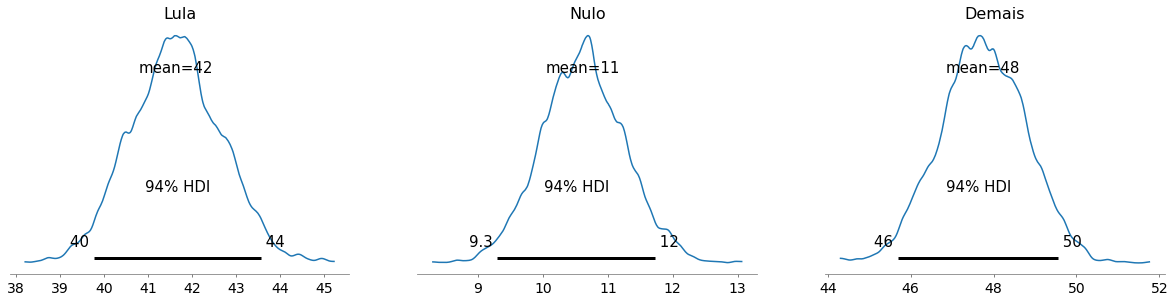

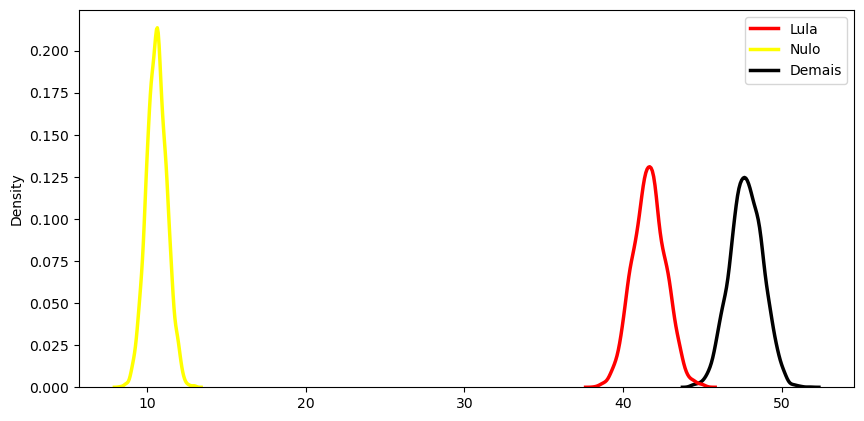

In [23]:
# a0 = np.array([100, 299, 100])
# D0 = np.random.dirichlet(a0, 1000)
# D0
post_pred_w = pd.DataFrame({'Lula': lula_w, 'Nulo': nulo_w, 'Demais': demais_w})
az.plot_posterior(post_pred_w.to_dict(orient='list'));
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)

sns.kdeplot(data=post_pred_w, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=100);

In [24]:
df_results_weekly

,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.389899,0.415657,0.439899,0.400000,0.425253,0.450013
0,2021-11-06,0.407569,0.431344,0.455604,0.390090,0.412906,0.437652
0,2021-11-19,0.388008,0.411794,0.436583,0.413280,0.438057,0.462339
0,2021-11-20,0.378000,0.402000,0.427000,0.443000,0.466500,0.491000
0,2021-11-24,0.364848,0.385859,0.408485,0.471919,0.494141,0.516364
0,2021-11-29,0.384860,0.401910,0.418277,0.493976,0.511253,0.528302
0,2021-12-05,0.386542,0.409627,0.432711,0.475442,0.499018,0.522593
0,2021-12-09,0.374167,0.404167,0.435000,0.467500,0.499167,0.530000
0,2021-12-11,0.387500,0.412000,0.437500,0.448000,0.473000,0.497500
0,2021-12-13,0.380500,0.404500,0.428012,0.464000,0.488000,0.512012


In [25]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()

for obj in df_by_mes.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS]).astype("int32")
    print(f">>> observed = {observed}")
    model_m = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)
    trace_m, ppc_m = sampling(model_m)
    posterior_m = ppc_m['current']
    prior = dirichlet.mle(posterior_m/posterior_m.sum(axis=1).reshape(-1, 1))
    qs = calc_prob_lula_win(model_m, trace_m, 50, ppc=ppc_m)
    print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
    post_prob = posterior_m/posterior_m.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



>>> observed = [6048 1507 7382]
14937
[420. 130. 450.]
[6048 1507 7382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_11, updaed_prior=[3073.29352128  772.41114534 3739.07014512],  qs=['0.0%', '0.0%', '0.0%'] <<<
lula= [0.39398641 0.40516837 0.41634866]
nulo= [0.09506594 0.10182768 0.1088572 ]
demais= [0.48189061 0.49287005 0.50438508]
>>> observed = [7356 1973 7586]
16915
[3073.29352128  772.41114534 3739.07014512]
[7356 1973 7586]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_12, updaed_prior=[3996.74613164 1059.95471615 4249.93343233],  qs=['0.1825%', '0.27999999999999997%', '0.3925%'] <<<
lula= [0.41956695 0.42950044 0.43931422]
nulo= [0.10747709 0.11386343 0.1205439 ]
demais= [0.44664351 0.456577   0.46674549]
>>> observed = [4833 1369 5249]
11451
[3996.74613164 1059.95471615 4249.93343233]
[4833 1369 5249]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2022_01, updaed_prior=[2723.75162014  756.62431236 2938.02148778],  qs=['0.095%', '0.18%', '0.27999999999999997%'] <<<
lula= [0.41201642 0.42424242 0.43646843]
nulo= [0.11003406 0.11789363 0.12610471]
demais= [0.44554842 0.45777661 0.46974063]
>>> observed = [1230  240 1530]
3000
[2723.75162014  756.62431236 2938.02148778]
[1230  240 1530]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2022_02, updaed_prior=[831.54023073 198.3171014  962.85785306],  qs=['0.04%', '0.08%', '0.13749999999999998%'] <<<
lula= [0.39533333 0.41733333 0.43933333]
nulo= [0.08633333 0.09966667 0.112675  ]
demais= [0.46166667 0.483      0.50466667]


model = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)


>>> mes=2021_12, updaed_prior=[4010.21159264 1063.82999647 4263.9625701 ],  qs=['0.1925%', '0.26%', '0.33999999999999997%'] <<<
lula= [0.4193896  0.42938221 0.43949305]
nulo= [0.10747857 0.11392255 0.1205439 ]
demais= [0.44670263 0.45651788 0.46668637]
>>> mes=2022_01, updaed_prior=[1986.94630475  542.79884705 2077.89947253],  qs=['7.24%', '7.6%', '8.0175%'] <<<
lula= [0.41708137 0.43120377 0.44559516]
nulo= [0.10867518 0.11782112 0.12723605]
demais= [0.43658373 0.45097512 0.46523201]

In [26]:
az.summary(trace_m)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],2701.036,48.274,2608.124,2788.777,0.872,0.617,3059.0,2313.0,1.0
random_walk[1],696.129,23.198,653.305,739.528,0.430,0.304,2906.0,2629.0,1.0
random_walk[2],3017.949,49.933,2927.056,3112.956,0.849,0.601,3456.0,2718.0,1.0
prior[0],0.417,0.006,0.405,0.429,0.000,0.000,2997.0,3194.0,1.0
prior[1],0.099,0.004,0.093,0.107,0.000,0.000,2438.0,2836.0,1.0
prior[2],0.483,0.006,0.471,0.495,0.000,0.000,3769.0,3653.0,1.0


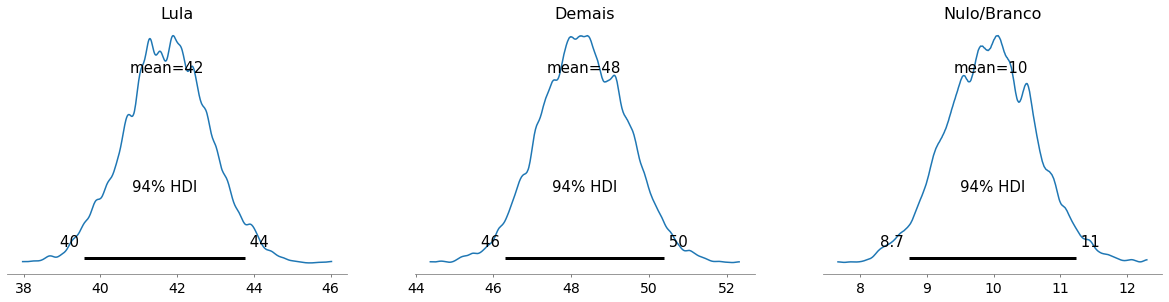

In [27]:
lula_m = ppc_m['current'][:,0] / ppc_m['current'].sum(axis=1) * 100.00
nulo_m = ppc_m['current'][:,1] / ppc_m['current'].sum(axis=1) * 100.00
demais_m = ppc_m['current'][:,2] / ppc_m['current'].sum(axis=1) * 100.00
post_pred = {'Lula': lula_m, 'Demais': demais_m, 'Nulo/Branco':nulo_m}
az.plot_posterior(post_pred);

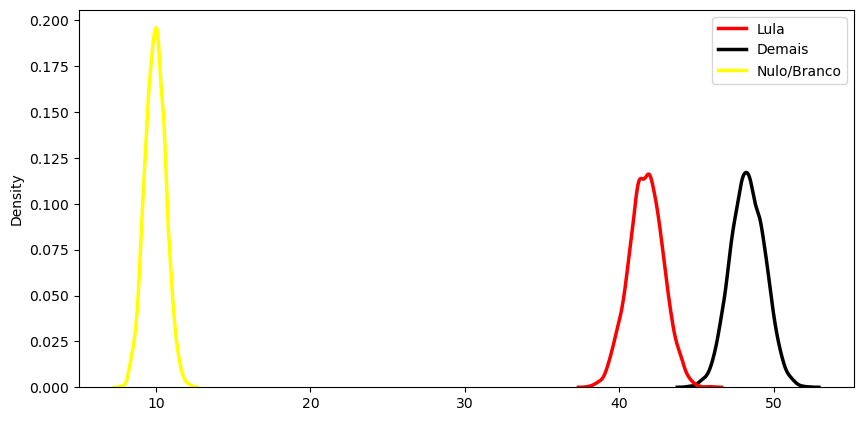

In [28]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','black','yellow'], linewidth=2.5, gridsize=500);

In [29]:
(post_pred['Lula'] > post_pred['Demais']).mean()

0.001

### DAILY

In [19]:
# for obj in df.itertuples():
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [20]:
to_dt = lambda x: pd.to_datetime(x)
day_zero = to_dt(df.data_pesquisa).min()
n_days = int((to_dt(df.data_pesquisa).max() - day_zero) / pd.Timedelta(days=1)) + 1
poll_day = ((to_dt(df.data_pesquisa) - day_zero) / pd.Timedelta(days=1)).astype(int)
print(n_days)
print(poll_day.shape)

95
(23,)


In [21]:
# prior = np.array([435, 110, 455]) 
to_predict = np.zeros((n_days, 3)) * np.nan

to_predict[poll_day,:] = np.array([df.LULA, df.NULO, df.OUTROS]).astype("int32").T

flat_prior = prior = np.array([400.0, 130.0, 470.0])

df_results_daily = pd.DataFrame({})
day = -1
for obj in to_predict:
    day += 1
    observed = np.array([obj[0], obj[1], obj[2]])
    print(f">>> observed = {observed}")
    
    model_d = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)
    trace_d, ppc_d = sampling(model_d)
    posterior_d = ppc_d['current']
    
    prior = dirichlet.mle(posterior_d/posterior_d.sum(axis=1).reshape(-1, 1))
    
    #qs = calc_prob_lula_win(model_d, trace_d, ppc=ppc_d)
    
    print(f">>> data_pesquisa={day}, updaed_prior={prior} <<<");
    post_prob = posterior_d/posterior_d.sum(axis=1).reshape(-1, 1)
    df_results_daily = df_results_daily.append(pd.DataFrame({"data":[day],
                                           "LulaLB":[np.quantile(post_prob[:, 0], q=HDI)[0]],
                                           "LulaM":[np.quantile(post_prob[:, 0], q=HDI)[1]],
                                           "LulaUB":[np.quantile(post_prob[:, 0], q=HDI)[2]],
                                           "DemaisLB":[np.quantile(post_prob[:, 2], q=HDI)[0]],
                                           "DemaisM":[np.quantile(post_prob[:, 2], q=HDI)[1]],
                                           "DemaisUB":[np.quantile(post_prob[:, 2], q=HDI)[2]]}))
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
df_results_daily



>>> observed = [880. 440. 660.]
1980.0
[400. 130. 470.]
[880. 440. 660.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


>>> data_pesquisa=0, updaed_prior=[594.28036711 229.20967639 607.33039274] <<<
lula= [0.38939394 0.41515152 0.44040404]
nulo= [0.14191919 0.16010101 0.17929293]
demais= [0.39949495 0.42474747 0.44949495]
>>> observed = [nan nan nan]
1000
[594.28036711 229.20967639 607.33039274]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=1, updaed_prior=[357.96114057 138.91208831 365.80587917] <<<
lula= [0.382 0.415 0.449]
nulo= [0.137 0.161 0.186]
demais= [0.391 0.424 0.456]
>>> observed = [990. 288. 783.]
2061.0
[357.96114057 138.91208831 365.80587917]
[990. 288. 783.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


>>> data_pesquisa=2, updaed_prior=[648.58791924 225.76075296 600.89429185] <<<
lula= [0.41436196 0.43959243 0.4648229 ]
nulo= [0.13537118 0.15283843 0.17176128]
demais= [0.38233867 0.40708394 0.43279961]
>>> observed = [nan nan nan]
1000
[648.58791924 225.76075296 600.89429185]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=3, updaed_prior=[373.24943753 130.56830824 346.89440576] <<<
lula= [0.405 0.439 0.473]
nulo= [0.13  0.153 0.177]
demais= [0.374 0.408 0.441]
>>> observed = [nan nan nan]
1000
[373.24943753 130.56830824 346.89440576]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=4, updaed_prior=[361.83856517 126.32642448 336.74883674] <<<
lula= [0.404 0.439 0.472]
nulo= [0.129 0.153 0.178]
demais= [0.376 0.408 0.442]
>>> observed = [nan nan nan]
1000
[361.83856517 126.32642448 336.74883674]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=5, updaed_prior=[327.61260495 113.88229064 305.03731045] <<<
lula= [0.404 0.439 0.476]
nulo= [0.128 0.152 0.178]
demais= [0.374 0.409 0.443]
>>> observed = [nan nan nan]
1000
[327.61260495 113.88229064 305.03731045]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=6, updaed_prior=[315.14926203 108.92229994 292.70095822] <<<
lula= [0.403 0.44  0.478]
nulo= [0.127 0.152 0.178]
demais= [0.373 0.408 0.444]
>>> observed = [nan nan nan]
1000
[315.14926203 108.92229994 292.70095822]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=7, updaed_prior=[330.93402417 118.22610492 312.1494343 ] <<<
lula= [0.399  0.4345 0.47  ]
nulo= [0.13  0.155 0.181]
demais= [0.374 0.41  0.445]
>>> observed = [nan nan nan]
1000
[330.93402417 118.22610492 312.1494343 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=8, updaed_prior=[336.86769287 119.54577693 319.68707792] <<<
lula= [0.4   0.434 0.468]
nulo= [0.129 0.154 0.18 ]
demais= [0.378 0.412 0.447]
>>> observed = [nan nan nan]
1000
[336.86769287 119.54577693 319.68707792]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=9, updaed_prior=[341.12287753 121.6726727  320.9135184 ] <<<
lula= [0.401 0.435 0.471]
nulo= [0.131 0.155 0.181]
demais= [0.374 0.409 0.444]
>>> observed = [nan nan nan]
1000
[341.12287753 121.6726727  320.9135184 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=10, updaed_prior=[331.36721794 116.30876819 311.4669548 ] <<<
lula= [0.402 0.436 0.473]
nulo= [0.128 0.153 0.179]
demais= [0.375 0.411 0.445]
>>> observed = [nan nan nan]
1000
[331.36721794 116.30876819 311.4669548 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=11, updaed_prior=[335.09880325 118.09069356 309.25786525] <<<
lula= [0.403975 0.44     0.474   ]
nulo= [0.13  0.155 0.18 ]
demais= [0.371 0.405 0.44 ]
>>> observed = [nan nan nan]
1000
[335.09880325 118.09069356 309.25786525]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=12, updaed_prior=[342.36267518 121.05138587 316.36817868] <<<
lula= [0.404 0.439 0.475]
nulo= [0.131 0.155 0.182]
demais= [0.372 0.406 0.44 ]
>>> observed = [nan nan nan]
1000
[342.36267518 121.05138587 316.36817868]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=13, updaed_prior=[348.10244369 121.47082071 315.17042259] <<<
lula= [0.409 0.443 0.479]
nulo= [0.13  0.155 0.18 ]
demais= [0.367 0.402 0.435]
>>> observed = [nan nan nan]
1000
[348.10244369 121.47082071 315.17042259]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=14, updaed_prior=[348.13831856 123.02047942 319.34111921] <<<
lula= [0.406 0.441 0.474]
nulo= [0.129 0.156 0.181]
demais= [0.371    0.404    0.437025]
>>> observed = [ 704.  270. 1044.]
2018.0
[348.13831856 123.02047942 319.34111921]
[ 704.  270. 1044.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=15, updaed_prior=[576.31596961 209.3679127  637.97738473] <<<
lula= [0.38007929 0.40485629 0.43062438]
nulo= [0.12933598 0.14667988 0.16600595]
demais= [0.42120912 0.44796829 0.47423191]
>>> observed = [ 740.  142. 1118.]
2000.0
[576.31596961 209.3679127  637.97738473]
[ 740.  142. 1118.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=16, updaed_prior=[635.80780113 203.67902766 765.41852958] <<<
lula= [0.373  0.396  0.4205]
nulo= [0.111 0.127 0.143]
demais= [0.453  0.477  0.5015]
>>> observed = [nan nan nan]
1000
[635.80780113 203.67902766 765.41852958]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=17, updaed_prior=[343.67957749 111.47586485 410.76299977] <<<
lula= [0.365 0.397 0.429]
nulo= [0.107 0.129 0.152]
demais= [0.442 0.474 0.507]
>>> observed = [nan nan nan]
1000
[343.67957749 111.47586485 410.76299977]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=18, updaed_prior=[301.39350801 101.62780598 364.22714357] <<<
lula= [0.358 0.393 0.427]
nulo= [0.109 0.132 0.157]
demais= [0.441 0.474 0.509]
>>> observed = [nan nan nan]
1000
[301.39350801 101.62780598 364.22714357]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=19, updaed_prior=[311.6181048  102.35522545 380.00533849] <<<
lula= [0.358 0.392 0.426]
nulo= [0.106 0.129 0.152]
demais= [0.444 0.479 0.514]
>>> observed = [ 850.  225. 1400.]
2475.0
[311.6181048  102.35522545 380.00533849]
[ 850.  225. 1400.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=20, updaed_prior=[640.12074556 193.59972405 890.82346528] <<<
lula= [0.34828283 0.37090909 0.39393939]
nulo= [0.09776768 0.11232323 0.12686869]
demais= [0.49252525 0.51676768 0.53979798]
>>> observed = [nan nan nan]
1000
[640.12074556 193.59972405 890.82346528]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=21, updaed_prior=[322.16824501  98.68967382 452.50080855] <<<
lula= [0.337 0.369 0.401]
nulo= [0.093 0.113 0.135]
demais= [0.485 0.518 0.552]
>>> observed = [nan nan nan]
1000
[322.16824501  98.68967382 452.50080855]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=22, updaed_prior=[290.3436242   88.6359949  405.84186948] <<<
lula= [0.337 0.37  0.403]
nulo= [0.092 0.113 0.136]
demais= [0.482 0.517 0.552]
>>> observed = [nan nan nan]
1000
[290.3436242   88.6359949  405.84186948]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=23, updaed_prior=[273.39884205  82.69734503 390.23614616] <<<
lula= [0.333 0.366 0.402]
nulo= [0.089 0.11  0.135]
demais= [0.488 0.523 0.558]
>>> observed = [nan nan nan]
1000
[273.39884205  82.69734503 390.23614616]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=24, updaed_prior=[284.62509866  87.53785047 407.20764308] <<<
lula= [0.332 0.365 0.399]
nulo= [0.091 0.112 0.135]
demais= [0.487 0.523 0.557]
>>> observed = [1883.  140. 2376.]
4399.0
[284.62509866  87.53785047 407.20764308]
[1883.  140. 2376.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=25, updaed_prior=[1104.41058938  174.98006641 1463.85088743] <<<
lula= [0.38485451 0.4025915  0.42168675]
nulo= [0.0550125  0.06365083 0.07319845]
demais= [0.5144351  0.53375767 0.55194931]
>>> observed = [nan nan nan]
1000
[1104.41058938  174.98006641 1463.85088743]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=26, updaed_prior=[371.67598946  58.44062534 492.92587834] <<<
lula= [0.371 0.403 0.434]
nulo= [0.048 0.063 0.079]
demais= [0.502 0.534 0.566]
>>> observed = [nan nan nan]
1000
[371.67598946  58.44062534 492.92587834]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=27, updaed_prior=[330.35262901  50.48976273 440.00174907] <<<
lula= [0.368 0.403 0.436]
nulo= [0.046 0.061 0.078]
demais= [0.502 0.536 0.57 ]
>>> observed = [nan nan nan]
1000
[330.35262901  50.48976273 440.00174907]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=28, updaed_prior=[320.72703894  49.11937012 421.92556762] <<<
lula= [0.372 0.405 0.439]
nulo= [0.046 0.062 0.08 ]
demais= [0.499 0.533 0.567]
>>> observed = [nan nan nan]
1000
[320.72703894  49.11937012 421.92556762]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=29, updaed_prior=[323.31183924  47.328799   423.52275518] <<<
lula= [0.372975 0.407    0.441   ]
nulo= [0.043 0.059 0.077]
demais= [0.499 0.533 0.568]
>>> observed = [nan nan nan]
1000
[323.31183924  47.328799   423.52275518]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=30, updaed_prior=[321.4924012   46.8410015  419.25598751] <<<
lula= [0.374 0.409 0.442]
nulo= [0.044 0.059 0.076]
demais= [0.497975 0.532    0.567   ]
>>> observed = [937. 244. 855.]
2036.0
[321.4924012   46.8410015  419.25598751]
[937. 244. 855.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=31, updaed_prior=[634.23252834 122.64737227 722.28721871] <<<
lula= [0.40422397 0.42829077 0.4543222 ]
nulo= [0.06876228 0.08300589 0.09724951]
demais= [0.46267191 0.48870334 0.5132613 ]
>>> observed = [nan nan nan]
1000
[634.23252834 122.64737227 722.28721871]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=32, updaed_prior=[369.24767134  70.44920477 420.00780286] <<<
lula= [0.396 0.43  0.462]
nulo= [0.064 0.082 0.101]
demais= [0.456 0.488 0.522]
>>> observed = [nan nan nan]
1000
[369.24767134  70.44920477 420.00780286]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=33, updaed_prior=[347.63610006  67.21518595 395.28566944] <<<
lula= [0.395 0.429 0.464]
nulo= [0.065 0.083 0.103]
demais= [0.454 0.488 0.521]
>>> observed = [nan nan nan]
1000
[347.63610006  67.21518595 395.28566944]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=34, updaed_prior=[328.19706347  63.55493046 369.03129542] <<<
lula= [0.397975 0.431    0.466   ]
nulo= [0.064 0.084 0.104]
demais= [0.45  0.485 0.52 ]
>>> observed = [444. 156. 600.]
1200.0
[328.19706347  63.55493046 369.03129542]
[444. 156. 600.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=35, updaed_prior=[379.96642535  88.83194581 450.00397466] <<<
lula= [0.3825     0.41333333 0.44583333]
nulo= [0.07833333 0.09666667 0.11583333]
demais= [0.45666667 0.49       0.52166667]
>>> observed = [nan nan nan]
1000
[379.96642535  88.83194581 450.00397466]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=36, updaed_prior=[332.61918644  77.78239473 396.97993813] <<<
lula= [0.378975 0.412    0.445   ]
nulo= [0.076 0.096 0.117]
demais= [0.458975 0.492    0.526   ]
>>> observed = [856. 306. 838.]
2000.0
[332.61918644  77.78239473 396.97993813]
[856. 306. 838.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


>>> data_pesquisa=37, updaed_prior=[608.01537113 171.2390608  674.14245023] <<<
lula= [0.3934875 0.4185    0.444    ]
nulo= [0.1015 0.118  0.134 ]
demais= [0.438 0.464 0.49 ]
>>> observed = [nan nan nan]
1000
[608.01537113 171.2390608  674.14245023]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=38, updaed_prior=[364.37786203 100.81528329 401.26359657] <<<
lula= [0.388 0.42  0.454]
nulo= [0.096 0.116 0.138]
demais= [0.431    0.463    0.495025]
>>> observed = [960. 280. 760.]
2000.0
[364.37786203 100.81528329 401.26359657]
[960. 280. 760.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


>>> data_pesquisa=39, updaed_prior=[647.75864684 182.90962293 633.58056917] <<<
lula= [0.4164875 0.4425    0.468    ]
nulo= [0.108  0.125  0.1415]
demais= [0.407 0.433 0.458]
>>> observed = [nan nan nan]
1000
[647.75864684 182.90962293 633.58056917]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=40, updaed_prior=[379.09934882 106.17645891 371.68703008] <<<
lula= [0.409 0.442 0.476]
nulo= [0.102 0.124 0.146]
demais= [0.401 0.434 0.467]
>>> observed = [nan nan nan]
1000
[379.09934882 106.17645891 371.68703008]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=41, updaed_prior=[356.4366354   99.38406098 347.23602579] <<<
lula= [0.409 0.444 0.478]
nulo= [0.102 0.123 0.147]
demais= [0.398975 0.432    0.466   ]
>>> observed = [440. 120. 450.]
1010.0
[356.4366354   99.38406098 347.23602579]
[440. 120. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


>>> data_pesquisa=42, updaed_prior=[358.59647004  99.68786136 354.23858662] <<<
lula= [0.40693069 0.44158416 0.47524752]
nulo= [0.1009901  0.12178218 0.14653465]
demais= [0.40195545 0.43564356 0.47029703]
>>> observed = [nan nan nan]
1000
[358.59647004  99.68786136 354.23858662]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=43, updaed_prior=[346.94390995  96.37722856 337.58614039] <<<
lula= [0.409 0.445 0.48 ]
nulo= [0.101 0.123 0.147]
demais= [0.398    0.432    0.467025]
>>> observed = [nan nan nan]
1000
[346.94390995  96.37722856 337.58614039]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=44, updaed_prior=[337.71044624  92.88334281 325.81467811] <<<
lula= [0.413 0.446 0.482]
nulo= [0.099 0.123 0.146]
demais= [0.395 0.431 0.466]
>>> observed = [nan nan nan]
1000
[337.71044624  92.88334281 325.81467811]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=45, updaed_prior=[345.63416224  94.02977172 332.80712736] <<<
lula= [0.412 0.448 0.482]
nulo= [0.099 0.122 0.146]
demais= [0.395 0.431 0.465]
>>> observed = [nan nan nan]
1000
[345.63416224  94.02977172 332.80712736]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=46, updaed_prior=[355.5544123   99.41578657 346.4482191 ] <<<
lula= [0.409975 0.444    0.478   ]
nulo= [0.102 0.124 0.147]
demais= [0.398    0.432    0.466025]
>>> observed = [1200.  330. 1470.]
3000.0
[355.5544123   99.41578657 346.4482191 ]
[1200.  330. 1470.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=47, updaed_prior=[851.54244512 236.30340159 928.45338652] <<<
lula= [0.401      0.42233333 0.44433333]
nulo= [0.103      0.11733333 0.13166667]
demais= [0.43933333 0.46033333 0.482     ]
>>> observed = [nan nan nan]
1000
[851.54244512 236.30340159 928.45338652]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=48, updaed_prior=[376.21151254 103.57210942 413.81200123] <<<
lula= [0.39  0.421 0.453]
nulo= [0.095 0.116 0.138]
demais= [0.431 0.463 0.495]
>>> observed = [nan nan nan]
1000
[376.21151254 103.57210942 413.81200123]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=49, updaed_prior=[337.65022637  93.97619402 369.10259195] <<<
lula= [0.389 0.422 0.455]
nulo= [0.095 0.117 0.14 ]
demais= [0.426975 0.461    0.496   ]
>>> observed = [nan nan nan]
1000
[337.65022637  93.97619402 369.10259195]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=50, updaed_prior=[339.83581826  92.83883756 365.78259497] <<<
lula= [0.391 0.426 0.46 ]
nulo= [0.095 0.116 0.139]
demais= [0.424 0.458 0.494]
>>> observed = [nan nan nan]
1000
[339.83581826  92.83883756 365.78259497]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=51, updaed_prior=[337.07539253  90.59246035 361.17703178] <<<
lula= [0.393 0.427 0.462]
nulo= [0.093975 0.115    0.138   ]
demais= [0.424 0.457 0.493]
>>> observed = [nan nan nan]
1000
[337.07539253  90.59246035 361.17703178]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8792532578914816, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=52, updaed_prior=[338.72481912  89.31564989 359.26409306] <<<
lula= [0.396 0.43  0.465]
nulo= [0.092 0.113 0.136]
demais= [0.422 0.456 0.49 ]
>>> observed = [nan nan nan]
1000
[338.72481912  89.31564989 359.26409306]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=53, updaed_prior=[349.13536808  92.30713446 364.9358252 ] <<<
lula= [0.399 0.433 0.467]
nulo= [0.093 0.114 0.137]
demais= [0.419 0.453 0.486]
>>> observed = [nan nan nan]
1000
[349.13536808  92.30713446 364.9358252 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=54, updaed_prior=[349.71071221  91.22294412 367.07352128] <<<
lula= [0.399 0.433 0.467]
nulo= [0.091 0.113 0.136]
demais= [0.42     0.454    0.488025]
>>> observed = [nan nan nan]
1000
[349.71071221  91.22294412 367.07352128]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=55, updaed_prior=[335.08455903  87.66891697 354.6505784 ] <<<
lula= [0.395 0.431 0.466]
nulo= [0.091 0.113 0.135]
demais= [0.42  0.456 0.491]
>>> observed = [nan nan nan]
1000
[335.08455903  87.66891697 354.6505784 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=56, updaed_prior=[344.05939224  89.72958883 366.81850367] <<<
lula= [0.395 0.43  0.465]
nulo= [0.091 0.112 0.134]
demais= [0.424 0.458 0.493]
>>> observed = [nan nan nan]
1000
[344.05939224  89.72958883 366.81850367]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=57, updaed_prior=[330.85154068  86.5110204  348.09730636] <<<
lula= [0.397 0.432 0.467]
nulo= [0.092 0.113 0.135]
demais= [0.42  0.455 0.491]
>>> observed = [nan nan nan]
1000
[330.85154068  86.5110204  348.09730636]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=58, updaed_prior=[334.5560635   90.07717905 352.47356065] <<<
lula= [0.396 0.431 0.465]
nulo= [0.094 0.116 0.139]
demais= [0.419 0.454 0.488]
>>> observed = [nan nan nan]
1000
[334.5560635   90.07717905 352.47356065]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=59, updaed_prior=[351.03934284  93.98503149 367.7817502 ] <<<
lula= [0.397 0.432 0.466]
nulo= [0.094 0.115 0.138]
demais= [0.419 0.452 0.488]
>>> observed = [nan nan nan]
1000
[351.03934284  93.98503149 367.7817502 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=60, updaed_prior=[337.85624966  88.99446108 353.34115386] <<<
lula= [0.398 0.433 0.469]
nulo= [0.093 0.114 0.136]
demais= [0.418    0.453    0.487025]
>>> observed = [nan nan nan]
1000
[337.85624966  88.99446108 353.34115386]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=61, updaed_prior=[334.48624708  88.7637799  345.23259307] <<<
lula= [0.401 0.435 0.471]
nulo= [0.093 0.115 0.139]
demais= [0.414975 0.449    0.483   ]
>>> observed = [nan nan nan]
1000
[334.48624708  88.7637799  345.23259307]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=62, updaed_prior=[321.34056032  85.51017873 331.99099396] <<<
lula= [0.4   0.435 0.471]
nulo= [0.094 0.116 0.139]
demais= [0.413 0.449 0.486]
>>> observed = [nan nan nan]
1000
[321.34056032  85.51017873 331.99099396]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=63, updaed_prior=[337.74052972  90.70400634 338.094368  ] <<<
lula= [0.406 0.44  0.475]
nulo= [0.097 0.118 0.142]
demais= [0.405975 0.441    0.477   ]
>>> observed = [nan nan nan]
1000
[337.74052972  90.70400634 338.094368  ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=64, updaed_prior=[343.04898666  94.31398496 345.92028388] <<<
lula= [0.403975 0.438    0.473   ]
nulo= [0.098 0.12  0.144]
demais= [0.407 0.441 0.477]
>>> observed = [nan nan nan]
1000
[343.04898666  94.31398496 345.92028388]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=65, updaed_prior=[343.09497583  94.5641476  341.91119107] <<<
lula= [0.405 0.44  0.475]
nulo= [0.098 0.121 0.144]
demais= [0.405 0.439 0.473]
>>> observed = [900. 240. 820.]
1960.0
[343.09497583  94.5641476  341.91119107]
[900. 240. 820.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


>>> data_pesquisa=66, updaed_prior=[620.54938555 168.6244587  596.99626841] <<<
lula= [0.42243622 0.44744898 0.47397959]
nulo= [0.10510204 0.12142857 0.13877551]
demais= [0.40510204 0.43061224 0.4561352 ]
>>> observed = [nan nan nan]
1000
[620.54938555 168.6244587  596.99626841]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.7105291753194202, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=67, updaed_prior=[394.47348497 105.43511035 373.81506351] <<<
lula= [0.419    0.452    0.483025]
nulo= [0.1   0.12  0.143]
demais= [0.395 0.428 0.461]
>>> observed = [nan nan nan]
1000
[394.47348497 105.43511035 373.81506351]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=68, updaed_prior=[359.81265318  96.13086447 339.27962376] <<<
lula= [0.418 0.452 0.486]
nulo= [0.099    0.121    0.143025]
demais= [0.394 0.426 0.461]
>>> observed = [440. 130. 450.]
1020.0
[359.81265318  96.13086447 339.27962376]
[440. 130. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


>>> data_pesquisa=69, updaed_prior=[367.28764507 100.68763775 353.63841023] <<<
lula= [0.41372549 0.44705882 0.48137255]
nulo= [0.10098039 0.12254902 0.14509804]
demais= [0.39705882 0.43039216 0.46372549]
>>> observed = [615. 165. 705.]
1485.0
[367.28764507 100.68763775 353.63841023]
[615. 165. 705.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


>>> data_pesquisa=70, updaed_prior=[487.17721458 132.9328533  495.80414059] <<<
lula= [0.40740741 0.43636364 0.46599327]
nulo= [0.1003367  0.11919192 0.13804714]
demais= [0.41481481 0.44410774 0.47340067]
>>> observed = [nan nan nan]
1000
[487.17721458 132.9328533  495.80414059]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=71, updaed_prior=[363.7121636   99.29745529 372.75332428] <<<
lula= [0.402 0.435 0.468]
nulo= [0.098 0.119 0.142]
demais= [0.413 0.446 0.479]
>>> observed = [nan nan nan]
1000
[363.7121636   99.29745529 372.75332428]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=72, updaed_prior=[338.92057738  93.05024748 346.94471632] <<<
lula= [0.401 0.435 0.47 ]
nulo= [0.097 0.119 0.143]
demais= [0.411 0.445 0.48 ]
>>> observed = [nan nan nan]
1000
[338.92057738  93.05024748 346.94471632]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=73, updaed_prior=[336.92315833  94.36049398 347.73393971] <<<
lula= [0.398 0.432 0.468]
nulo= [0.099 0.121 0.145]
demais= [0.411 0.446 0.481]
>>> observed = [nan nan nan]
1000
[336.92315833  94.36049398 347.73393971]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=74, updaed_prior=[327.38396857  90.4849314  337.70337848] <<<
lula= [0.397 0.433 0.471]
nulo= [0.098 0.119 0.142]
demais= [0.411 0.447 0.483]
>>> observed = [1260.  360. 1350.]
2970.0
[327.38396857  90.4849314  337.70337848]
[1260.  360. 1350.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


>>> data_pesquisa=75, updaed_prior=[856.48938281 240.57854911 899.28396845] <<<
lula= [0.40740741 0.42929293 0.45084175]
nulo= [0.10572391 0.12053872 0.13501684]
demais= [0.42895623 0.45050505 0.47205387]
>>> observed = [nan nan nan]
1000
[856.48938281 240.57854911 899.28396845]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=76, updaed_prior=[383.98535054 108.09392451 403.78926088] <<<
lula= [0.397 0.429 0.461]
nulo= [0.1   0.12  0.143]
demais= [0.418 0.451 0.483]
>>> observed = [nan nan nan]
1000
[383.98535054 108.09392451 403.78926088]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=77, updaed_prior=[331.71952368  92.43680403 348.97867169] <<<
lula= [0.395 0.429 0.464]
nulo= [0.097 0.119 0.143]
demais= [0.416 0.451 0.486]
>>> observed = [ 738.  214. 1044.]
1996.0
[331.71952368  92.43680403 348.97867169]
[ 738.  214. 1044.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


>>> data_pesquisa=78, updaed_prior=[578.44279731 163.52573449 683.30126944] <<<
lula= [0.37975952 0.40581162 0.43186373]
nulo= [0.09819639 0.11472946 0.13126253]
demais= [0.45290581 0.47945892 0.50601202]
>>> observed = [nan nan nan]
1000
[578.44279731 163.52573449 683.30126944]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=79, updaed_prior=[349.58891153  99.53916619 416.05875677] <<<
lula= [0.372 0.404 0.437]
nulo= [0.094 0.115 0.137]
demais= [0.448 0.481 0.514]
>>> observed = [nan nan nan]
1000
[349.58891153  99.53916619 416.05875677]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=80, updaed_prior=[316.06624575  88.42379321 372.23377962] <<<
lula= [0.373 0.407 0.44 ]
nulo= [0.092 0.114 0.137]
demais= [0.445 0.479 0.513]
>>> observed = [nan nan nan]
1000
[316.06624575  88.42379321 372.23377962]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.88217083158283, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=81, updaed_prior=[321.3374214   87.45265902 373.61487036] <<<
lula= [0.377 0.411 0.446]
nulo= [0.09  0.112 0.135]
demais= [0.442 0.478 0.511]
>>> observed = [880. 260. 880.]
2020.0
[321.3374214   87.45265902 373.61487036]
[880. 260. 880.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


>>> data_pesquisa=82, updaed_prior=[599.38599272 168.60596926 657.48727985] <<<
lula= [0.39455446 0.42029703 0.44653465]
nulo= [0.10148515 0.11831683 0.13514851]
demais= [0.43563119 0.46089109 0.48663366]
>>> observed = [nan nan nan]
1000
[599.38599272 168.60596926 657.48727985]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=83, updaed_prior=[364.34490179 103.05123391 397.41661257] <<<
lula= [0.388 0.422 0.455]
nulo= [0.099 0.119 0.142]
demais= [0.426 0.46  0.492]
>>> observed = [nan nan nan]
1000
[364.34490179 103.05123391 397.41661257]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=84, updaed_prior=[337.71463051  94.98886336 373.6936357 ] <<<
lula= [0.385 0.419 0.453]
nulo= [0.096 0.118 0.141]
demais= [0.429 0.464 0.498]
>>> observed = [nan nan nan]
1000
[337.71463051  94.98886336 373.6936357 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=85, updaed_prior=[322.69001706  90.70685814 355.8636523 ] <<<
lula= [0.384 0.419 0.454]
nulo= [0.097 0.118 0.142]
demais= [0.428 0.463 0.498]
>>> observed = [nan nan nan]
1000
[322.69001706  90.70685814 355.8636523 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=86, updaed_prior=[326.84105176  91.75145629 358.23277209] <<<
lula= [0.386 0.421 0.455]
nulo= [0.096 0.118 0.141]
demais= [0.427 0.461 0.496]
>>> observed = [nan nan nan]
1000
[326.84105176  91.75145629 358.23277209]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=87, updaed_prior=[327.77356465  90.81358065 356.30959518] <<<
lula= [0.389 0.423 0.458]
nulo= [0.095 0.117 0.141]
demais= [0.425 0.46  0.494]
>>> observed = [nan nan nan]
1000
[327.77356465  90.81358065 356.30959518]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=88, updaed_prior=[326.32128724  90.20788662 354.19481456] <<<
lula= [0.389 0.423 0.458]
nulo= [0.095 0.117 0.14 ]
demais= [0.425 0.46  0.494]
>>> observed = [1230.  240. 1530.]
3000.0
[326.32128724  90.20788662 354.19481456]
[1230.  240. 1530.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


>>> data_pesquisa=89, updaed_prior=[831.35238026 196.56939206 966.52155075] <<<
lula= [0.39466667 0.417      0.43833333]
nulo= [0.08566667 0.09866667 0.11166667]
demais= [0.46299167 0.48466667 0.50666667]
>>> observed = [ 810.  208. 1001.]
2019.0
[831.35238026 196.56939206 966.52155075]
[ 810.  208. 1001.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


>>> data_pesquisa=90, updaed_prior=[702.6359407  168.98225832 827.5260446 ] <<<
lula= [0.38979693 0.41406637 0.43635463]
nulo= [0.08568598 0.09955423 0.11342249]
demais= [0.46359584 0.4863794  0.51114413]
>>> observed = [nan nan nan]
1000
[702.6359407  168.98225832 827.5260446 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=91, updaed_prior=[358.09154108  86.48146608 422.52298064] <<<
lula= [0.38  0.413 0.446]
nulo= [0.08  0.1   0.119]
demais= [0.454 0.487 0.52 ]
>>> observed = [nan nan nan]
1000
[358.09154108  86.48146608 422.52298064]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=92, updaed_prior=[327.15385616  77.88746581 384.62938046] <<<
lula= [0.38  0.414 0.447]
nulo= [0.078 0.098 0.12 ]
demais= [0.453 0.487 0.522]
>>> observed = [nan nan nan]
1000
[327.15385616  77.88746581 384.62938046]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=93, updaed_prior=[333.70722428  79.177372   393.69328194] <<<
lula= [0.38  0.413 0.448]
nulo= [0.078 0.098 0.119]
demais= [0.454 0.488 0.523]
>>> observed = [900. 260. 840.]
2000.0
[333.70722428  79.177372   393.69328194]
[900. 260. 840.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


>>> data_pesquisa=94, updaed_prior=[611.43612567 158.06448135 661.79342653] <<<
lula= [0.4025 0.427  0.453 ]
nulo= [0.0945 0.1105 0.1265]
demais= [0.436  0.462  0.4885]


,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,0,0.389394,0.415152,0.440404,0.399495,0.424747,0.449495
0,1,0.382000,0.415000,0.449000,0.391000,0.424000,0.456000
0,2,0.414362,0.439592,0.464823,0.382339,0.407084,0.432800
0,3,0.405000,0.439000,0.473000,0.374000,0.408000,0.441000
0,4,0.404000,0.439000,0.472000,0.376000,0.408000,0.442000
0,5,0.404000,0.439000,0.476000,0.374000,0.409000,0.443000
0,6,0.403000,0.440000,0.478000,0.373000,0.408000,0.444000
0,7,0.399000,0.434500,0.470000,0.374000,0.410000,0.445000
0,8,0.400000,0.434000,0.468000,0.378000,0.412000,0.447000
0,9,0.401000,0.435000,0.471000,0.374000,0.409000,0.444000


In [22]:
trace_d, ppc_d = sampling(model_d)
posterior_d = ppc_d['current']
az.summary(trace_d)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],3404.540,66.789,3287.162,3535.103,1.255,0.889,2840.0,2542.0,1.0
random_walk[1],848.660,32.940,786.306,908.659,0.630,0.447,2781.0,2637.0,1.0
random_walk[2],3807.394,69.377,3675.665,3934.801,1.186,0.839,3411.0,2539.0,1.0
prior[0],0.428,0.007,0.415,0.442,0.000,0.000,2628.0,2368.0,1.0
prior[1],0.110,0.004,0.102,0.118,0.000,0.000,2342.0,2264.0,1.0
prior[2],0.462,0.007,0.448,0.475,0.000,0.000,3301.0,2848.0,1.0


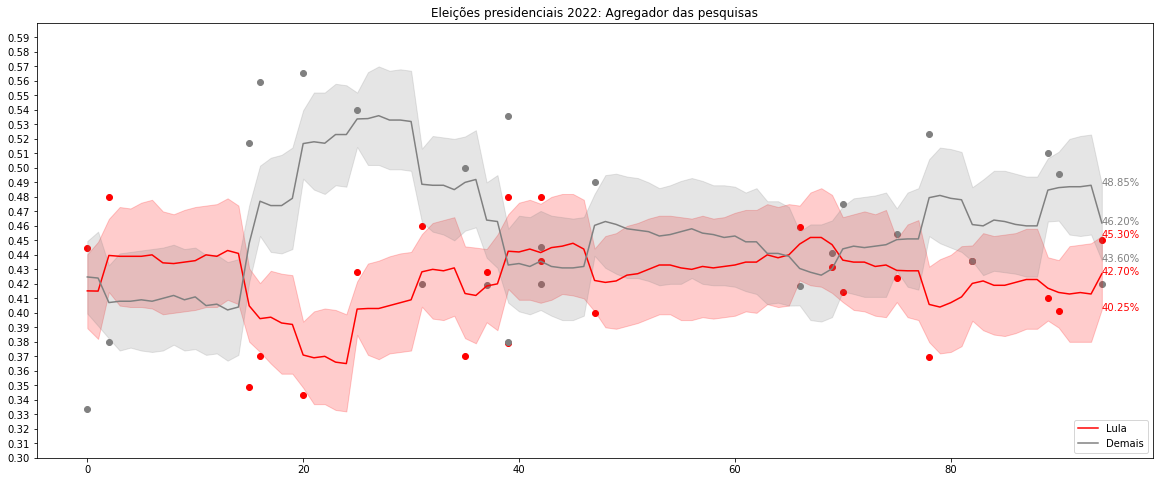

In [23]:
dfrw = df_results_daily.groupby('data').mean().reset_index(col_level=1).copy()
dfrw.columns = dfrw.columns.to_flat_index()
# print(dfrw)
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))

plt.scatter(dfrw.data[poll_day], df.LULA/df.TOTAL, color='red')
plt.scatter(dfrw.data[poll_day], df["OUTROS"]/df["TOTAL"], color='gray')
plt.plot(dfrw.data, dfrw.LulaM, color='red', label="Lula")
plt.fill_between(x=dfrw.data, y1=dfrw.LulaLB, y2=dfrw.LulaUB, alpha=0.2, color='red')
plt.plot(dfrw.data, dfrw.DemaisM, color='gray', label="Demais")
plt.fill_between(x=dfrw.data, y1=dfrw.DemaisLB, y2=dfrw.DemaisUB, alpha=0.2, color='gray')

plt.text(dfrw.data.values[-1], dfrw.LulaUB.values[-1]-.001, f'{dfrw.LulaUB.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaM.values[-1]-.001, f'{dfrw.LulaM.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaLB.values[-1]-.001, f'{dfrw.LulaLB.values[-1] * 100:.2f}%', color='red')

plt.text(dfrw.data.values[-1], dfrw.DemaisUB.values[-1]-.001, f'{dfrw.DemaisUB.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisM.values[-1]-.001, f'{dfrw.DemaisM.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisLB.values[-1]-.001, f'{dfrw.DemaisLB.values[-1] * 100:.2f}%', color='gray')
plt.legend(loc='lower right')
plt.show()

## Playground

In [35]:
import math
1 - stats.norm.cdf(0, loc=-1, scale=math.sqrt(5))

0.32736042300928847

In [36]:
import scipy as sp
true_p = sp.stats.dirichlet(6.0 * np.array([0.45, 0.3, 0.15, 0.9, 0.01])).rvs(size=10)
observed = np.vstack([sp.stats.multinomial(n=50, p=p_i).rvs() for p_i in true_p])



In [37]:
observed.sum(axis=1)

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

In [38]:
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
import plotly.io as pio
# Default is plotly_mimetype+notebook, but jekyll fails to parse plotly_mimetype.
pio.renderers.default = 'notebook_connected'

# Inject the missing require.js dependency.
from IPython.display import display, HTML
js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
display(HTML(js))
import plotly.express as px

# df_gm = px.data.gapminder()
# px.scatter(df_gm, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
#            size="pop", color="continent", hover_name="country",
#            log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])


In [39]:
# hide_input
# This cell is required for the export to HTML to work.


In [40]:
observed_prior = np.array([7356., 1973., 7578.])
prior = []
N = 4000
for it in range(N):
    b = stats.beta.rvs(a=5, b=1, size=3)
    # print(b)
    # print(observed_prior * b)
    diric = stats.dirichlet.rvs(observed_prior * b,)
    # print(diric[0])
    prior.append(diric[0])
prior = np.array(prior)
print(prior[:4])

[[0.39555127 0.12240872 0.48204001]
 [0.42214073 0.11667742 0.46118185]
 [0.37548353 0.16068079 0.46383568]
 [0.48537601 0.11856733 0.39605665]]


In [41]:

print((prior[:,0] > prior[:,2]).mean())
print(prior.shape)


0.4205
(4000, 3)


In [42]:
posterior = []
for it in range(N):
    mn = stats.multinomial.rvs(n=3000, p=[1340/3000, 370/3000, 1290/3000])
    posterior.append(mn * prior[it])
posterior = np.array(posterior)



In [43]:
post = posterior#/posterior.sum(axis=1).reshape(4000,1)
print(post.sum(axis=1))
print(post[:10, 0])
print(post[:10, 2])

[1202.61071202 1199.58385117 1159.93624357 ... 1194.43325476 1215.02321396
 1204.93916266]
[536.36751946 569.88998983 497.14018955 670.30427501 612.17881568
 548.12564674 608.66924614 564.66047607 474.51494291 618.42102588]
[623.27773049 585.23976463 602.05871485 506.55646078 561.6581887
 643.01708862 585.73236616 580.72640056 674.09135822 588.76793538]


In [44]:
lula = post[:, 0]
others = post[:, 2]
print((lula > others).mean())

0.50225


In [45]:
simul = []
for it in range(N):
    idx = np.random.choice(N,1)[0]
    #print(idx)
    #print(post[idx])
    dir2 = stats.dirichlet.rvs(post[idx])[0]
    simul.append(dir2)
dir2 = np.array(simul)

In [46]:
dir2

array([[0.55144331, 0.03826189, 0.4102948 ],
       [0.49626279, 0.05634609, 0.44739112],
       [0.24815464, 0.05276205, 0.69908331],
       ...,
       [0.41845196, 0.05431018, 0.52723786],
       [0.51076235, 0.04074497, 0.44849268],
       [0.51308485, 0.01939574, 0.46751941]])

In [47]:
lula = dir2[:, 0]
others = dir2[:, 2]
print((lula > others).mean())

0.50025


In [48]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [49]:
np.linspace(0,1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [50]:
x = np.arange(5,10)

In [51]:
np.concatenate([[x[0] - 5], x, [x[-1] + 5]])

array([ 0,  5,  6,  7,  8,  9, 14])

In [52]:
1.96 * np.sqrt((0.5**2)/3000)

0.017892270211835426

In [53]:
1./(1./0.01789 + 1./0.0200)

0.009443124835048826

In [54]:
1/100

0.01

In [55]:
1/(1./0.01789 + 1./0.0200)

0.009443124835048826

In [56]:
X = np.arange(1, 100)
X.mean(), X.std()

(50.0, 28.577380332470412)

20.51443659518261 4.2428566329970945


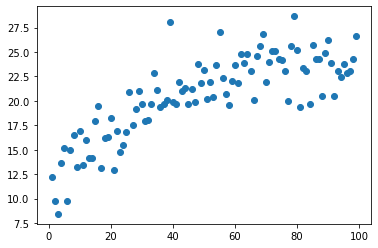

In [57]:
Y = 12*(np.sin(X/50) + 1) + np.random.normal(0, 2, X.size)
print(Y.mean(), Y.std())
plt.scatter(X, Y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grw]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


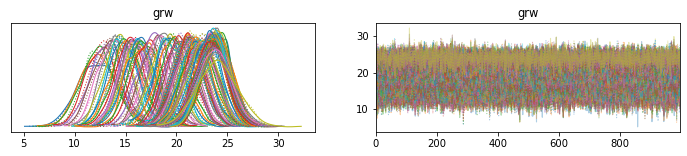

In [58]:
with pm.Model() as grw:
    grw = pm.GaussianRandomWalk('grw', mu=0, sd=1.0, shape=X.size)
    
    observed = pm.Normal('observed', mu=grw, sigma=Y.std(), observed=Y)
    
    trace = pm.sample(1000, tune=1000, progressbar=True, 
                          return_inferencedata=True)
    summary = az.summary(trace) # used below
    az.plot_trace(trace)  


In [59]:
trace.posterior.grw.mean(axis=0).mean(axis=0)

<xarray.DataArray 'grw' (grw_dim_0: 99)>
array([12.29023821, 12.3017939 , 12.39985743, 12.77314112, 13.11447944,
       13.36885527, 13.7703244 , 14.11878545, 14.36732042, 14.65071753,
       14.80054256, 15.05708658, 15.20777733, 15.44260097, 15.73460676,
       15.95429092, 15.9336733 , 16.07936179, 16.22004054, 16.36817507,
       16.40138786, 16.6156566 , 16.83946804, 17.16549593, 17.57342122,
       17.9949875 , 18.33058781, 18.64728163, 18.95429446, 19.12705479,
       19.30306921, 19.5263637 , 19.86637195, 20.17817752, 20.34383846,
       20.4529181 , 20.64034053, 20.89670561, 21.20808084, 21.08076936,
       21.07354673, 21.15577968, 21.18701677, 21.21004511, 21.27174275,
       21.31478597, 21.44755047, 21.66821214, 21.769683  , 21.87678167,
       21.88628519, 22.03263701, 22.18313001, 22.42004107, 22.58011646,
       22.48447244, 22.4128202 , 22.40771428, 22.58236716, 22.81054008,
       22.95707313, 23.19705471, 23.30319158, 23.41418041, 23.44072242,
       23.48163465, 23.75053674, 23.94441268, 24.03834576, 24.00042058,
       24.04922126, 24.11337325, 24.07161545, 23.97937324, 23.86903839,
       23.76289737, 23.74034653, 23.86695909, 23.90808859, 23.73492942,
       23.42959894, 23.37960558, 23.31295692, 23.28100207, 23.4611308 ,
       23.49416577, 23.46083545, 23.41547394, 23.51252302, 23.54685903,
       23.46033883, 23.33453365, 23.35838517, 23.38010593, 23.47495893,
       23.57149624, 23.69840035, 23.84754445, 23.98797411])
Coordinates:
  * grw_dim_0  (grw_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98

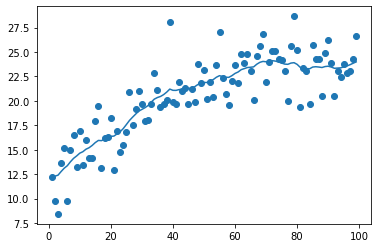

In [60]:
plt.scatter(X, Y)
plt.plot(X, trace.posterior.grw.mean(axis=0).mean(axis=0))

In [61]:
# az.summary(trace)
trace.posterior.grw.mean(axis=0).shape

(1000, 99)

In [62]:
qs = np.quantile(trace.posterior.grw.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)


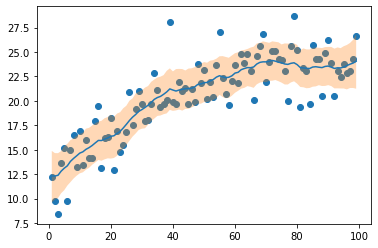

In [63]:
plt.scatter(X, Y)
plt.plot(X, qs[1])
plt.fill_between(x=X,y1=qs[0], y2=qs[2], alpha=0.3)

In [24]:
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [25]:
#YL = raw_df.query("partido == 'PT' ")["percentual"]
YL = 100.00 * df.LULA/df.TOTAL
OL = 100.00 * df.OUTROS/df.TOTAL
POLLSTERS = pd.Categorical(df.instituto)
print(POLLSTERS, POLLSTERS.codes)
P = len(POLLSTERS.unique())
print(P)
#print(OL)
#YL = YL.append(to_append=pd.Series([42, 36.9, 44]))
#OL = OL.append(to_append=pd.Series([45, 45, 48, 44,45, 44]))
#YL = YL.append(to_append=pd.Series([np.nan]*10))

XL = np.arange(YL.size)
# XL = df_results_weekly.data
# YL = YL.append(to_append=pd.Series([42]))
# YL[10:13]=np.nan

['Vox Populi', 'Quaest', 'Paraná Pesquisas', 'Futura', 'PoderData', ..., 'Futura', 'Ipespe', 'PoderData', 'Paraná Pesquisas', 'Quaest']
Length: 23
Categories (11, object): ['Atlas', 'Datafolha', 'Futura', 'Ideia Big Data', ..., 'Paraná Pesquisas', 'PoderData', 'Quaest', 'Vox Populi'] [10  9  7  2  8  0  9  3  6  2  4  1  5  8  9  5  3  8  2  5  8  7  9]
11


In [35]:
print(POLLSTERS.shape, YL.shape, OL.shape)
PRESUMED_STD = np.sqrt((50**2)/2000)
print(PRESUMED_STD)
from datetime import datetime

(23,) (23,) (23,)
1.118033988749895


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [demais, lula, poll_bias, inov]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 51 seconds.


13:10:58


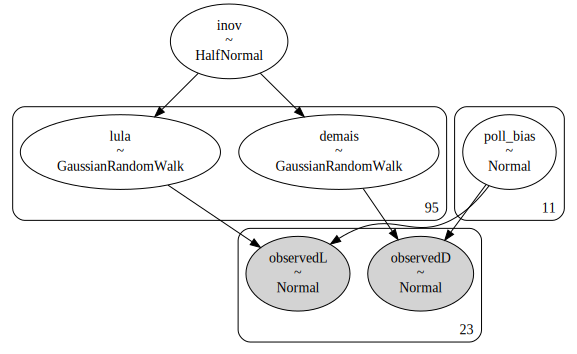

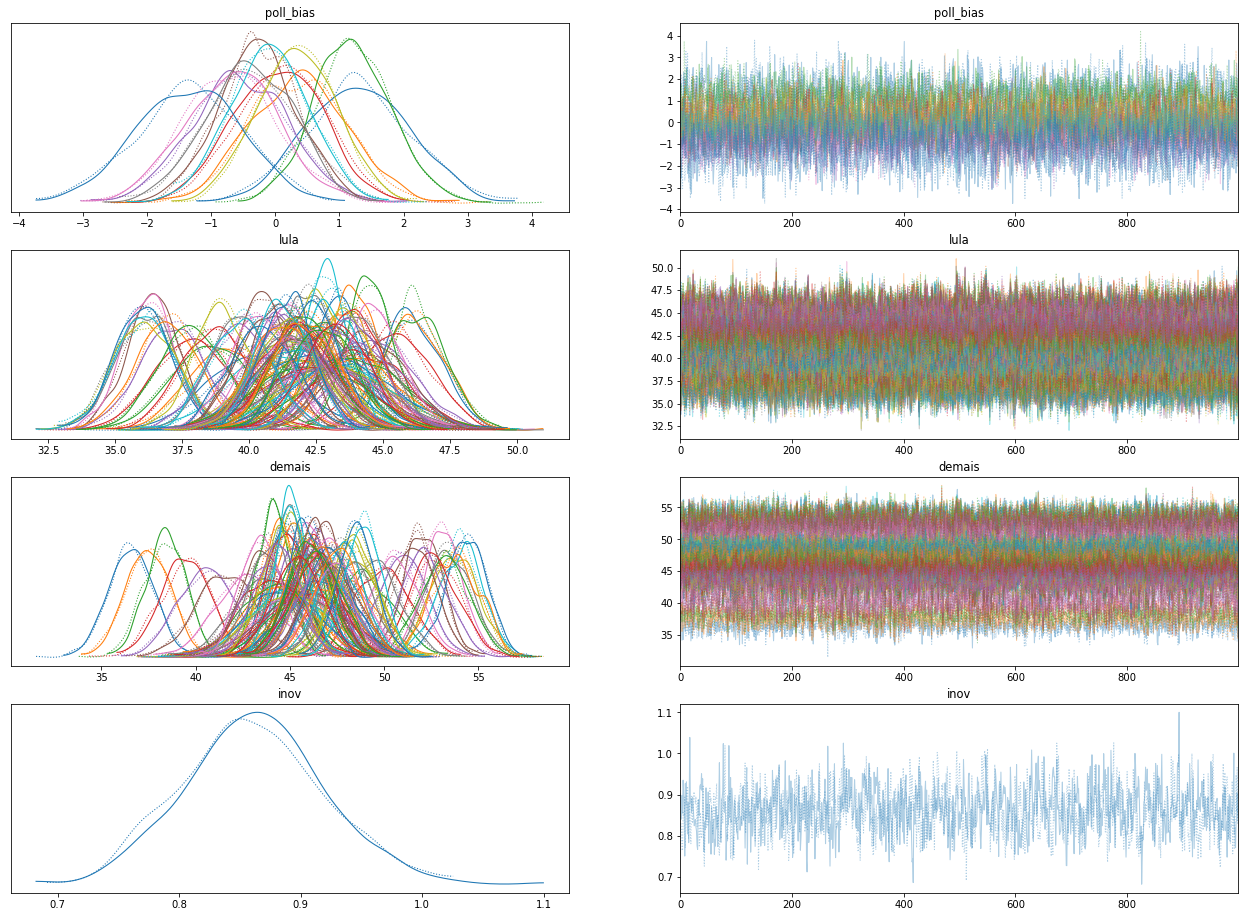

In [47]:
with pm.Model() as grw:
    
    inov = pm.HalfNormal('inov', sigma=0.10)
    
    #poll_bias = pm.Cauchy("poll_bias", alpha=0, beta=10, shape=P)
    
    #zero_sum_house_bias = pm.Deterministic('zero_sum_poll_bias', var=(poll_bias - poll_bias.mean()))
    poll_bias = pm.Normal("poll_bias", 0, 1.00, shape=P)
    
    grw_lula = pm.GaussianRandomWalk('lula', mu=0, sd=inov, shape=n_days)
    
    grw_demais = pm.GaussianRandomWalk('demais', mu=0, sd=inov, shape=n_days)
    
    #sigma = pm.HalfCauchy("sigma", beta=10)
    

    pm.Normal('observedL', mu=grw_lula[poll_day] + poll_bias[POLLSTERS.codes], sigma=PRESUMED_STD**2, observed=YL)
    pm.Normal('observedD', mu=grw_demais[poll_day] + poll_bias[POLLSTERS.codes], sigma=PRESUMED_STD**2, observed=OL)
    
    trace = pm.sample(1000, tune=2000, progressbar=True, return_inferencedata=True)

    summary = az.summary(trace) # used below
    az.plot_trace(trace, figsize=(22,16))  
print(datetime.now().strftime("%H:%M:%S"))
pm.model_to_graphviz(grw)

In [48]:
print(trace.posterior.lula.mean(axis=0).shape)
print(trace.posterior.demais.mean(axis=0).shape)

(1000, 95)
(1000, 95)


In [49]:
poll_day.values

array([ 0,  2, 15, 16, 20, 25, 31, 35, 37, 39, 39, 42, 42, 47, 66, 69, 70,
       75, 78, 82, 89, 90, 94])

In [50]:
datas = []
print(n_days)
for d in range(n_days):
    datas.append((pd.to_datetime(df.data_pesquisa).min() + pd.Timedelta(days=d)).strftime("%Y-%m-%d"))

95


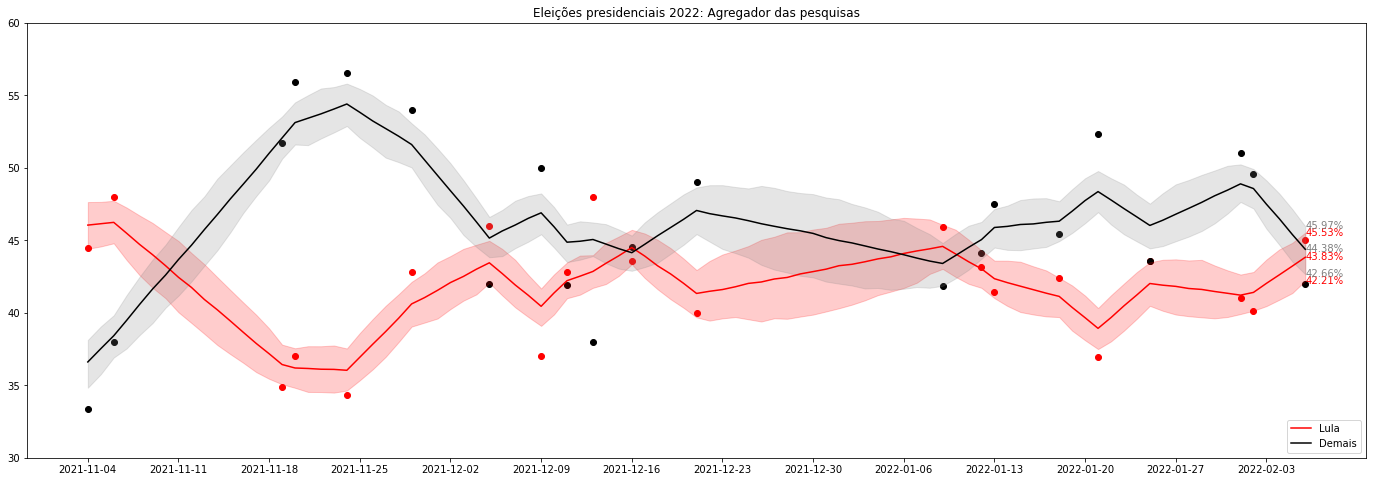

In [51]:
qsL = np.quantile(trace.posterior.lula.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
qsD = np.quantile(trace.posterior.demais.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
# print(qs[0].shape)
pdv = poll_day.values
# df_rand_walk = pd.DataFrame({'data_pesquisa': df.data_pesquisa, 'LULA': 100.0 * df.LULA/df.TOTAL, 'LB': qs[0][pdv], 'M':qs[1][pdv], 'UB':qs[2][pdv]})
# print(df_rand_walk)
# table_rw = df_rand_walk.groupby('data_pesquisa').mean().reset_index(col_level=1).copy()
# table_rw.columns = table_rw.columns.to_flat_index()
# print(table_rw)

plt.figure(figsize=(24,8))
plt.ylim(30, 60)
L = np.zeros(n_days) * np.nan
O = L.copy()
L[poll_day.values] = 100.0 * df.LULA/df.TOTAL
O[poll_day.values] = 100.0 * df.OUTROS/df.TOTAL
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.scatter(datas, L, color='red')
plt.scatter(datas, O, color='black')
plt.plot(datas, qsL[1], color='red', label="Lula")
plt.fill_between(x=datas, y1=qsL[0], y2=qsL[2], alpha=0.2, color='red')
plt.text(datas[-1], qsL[0][-1]-.2, f'{qsL[0][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[1][-1]-.2, f'{qsL[1][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[2][-1]-.2, f'{qsL[2][-1]:.2f}%', color='red');

plt.plot(datas, qsD[1], color='black', label="Demais");
plt.fill_between(x=datas, y1=qsD[0], y2=qsD[2], alpha=0.2, color='gray');
plt.text(datas[-1], qsD[0][-1]-.2, f'{qsD[0][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[1][-1]-.2, f'{qsD[1][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[2][-1]-.2, f'{qsD[2][-1]:.2f}%', color='gray');
plt.xticks([d for i,d in enumerate(datas) if i % 7 ==0]);
plt.legend(loc='lower right');

## MULTIVARIATE

In [52]:
PRESUMED_STD = 1.2
cov = np.cov(np.array([YL, OL]))
print(cov)
print(np.array([[1.7]]))

[[ 16.90482474 -21.46722425]
 [-21.46722425  38.49815844]]
[[1.7]]


In [53]:
import theano.tensor as tt
from datetime import datetime
with pm.Model() as grw:
    
    inov = pm.HalfNormal('inov', sigma=0.15)
    
    # poll_bias = pm.Cauchy("poll_bias", alpha=0, beta=10, shape=P)
    
    # zero_sum_house_bias = pm.Deterministic('zero_sum_poll_bias', var=(poll_bias - poll_bias.mean()))
    # poll_bias = pm.Normal("poll_bias", 0, 1.00, shape=P)
    sd_dist = pm.Exponential.dist(1.0)
    chol, _, _ = pm.LKJCholeskyCov('chol_cov', n=2, eta=4, sd_dist=sd_dist, compute_corr=True)
    
    grw_lula = pm.GaussianRandomWalk('lula', mu=0, sd=inov, shape=n_days)
    
    grw_demais = pm.GaussianRandomWalk('demais', mu=0, sd=inov, shape=n_days)
    cov = tt.dot(chol, chol.T)
    
    pm.MvStudentT('observed', nu=len(YL)-1, mu=tt.stack([grw_lula[poll_day], grw_demais[poll_day]], axis=1), cov=cov, observed=np.array([YL, OL]).T)
    
    trace = pm.sample(1000, tune=1000, progressbar=True, return_inferencedata=True)

    summary = az.summary(trace) # used below
    az.plot_trace(trace, figsize=(22,16))  
print(datetime.now().strftime("%H:%M:%S"))
pm.model_to_graphviz(grw)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [demais, lula, chol_cov, inov]


ValueError: Not enough samples to build a trace.

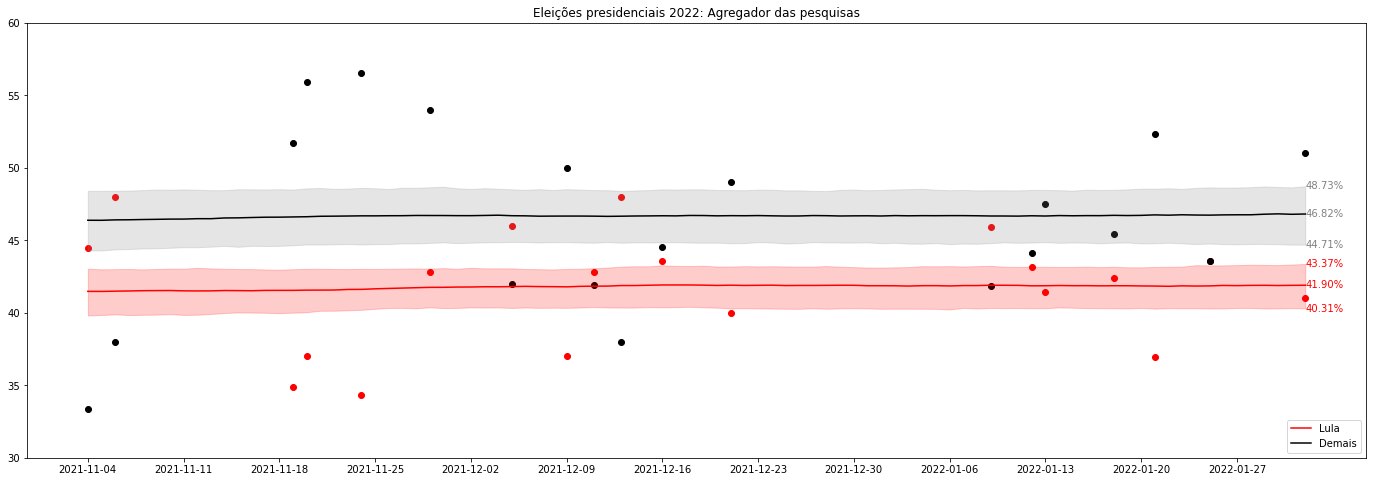

In [ ]:
qsL = np.quantile(trace.posterior.lula.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
qsD = np.quantile(trace.posterior.demais.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
# print(qs[0].shape)
pdv = poll_day.values
# df_rand_walk = pd.DataFrame({'data_pesquisa': df.data_pesquisa, 'LULA': 100.0 * df.LULA/df.TOTAL, 'LB': qs[0][pdv], 'M':qs[1][pdv], 'UB':qs[2][pdv]})
# print(df_rand_walk)
# table_rw = df_rand_walk.groupby('data_pesquisa').mean().reset_index(col_level=1).copy()
# table_rw.columns = table_rw.columns.to_flat_index()
# print(table_rw)

plt.figure(figsize=(24,8))
plt.ylim(30, 60)
L = np.zeros(n_days) * np.nan
O = L.copy()
L[poll_day.values] = 100.0 * df.LULA/df.TOTAL
O[poll_day.values] = 100.0 * df.OUTROS/df.TOTAL
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.scatter(datas, L, color='red')
plt.scatter(datas, O, color='black')
plt.plot(datas, qsL[1], color='red', label="Lula")
plt.fill_between(x=datas, y1=qsL[0], y2=qsL[2], alpha=0.2, color='red')
plt.text(datas[-1], qsL[0][-1]-.2, f'{qsL[0][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[1][-1]-.2, f'{qsL[1][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[2][-1]-.2, f'{qsL[2][-1]:.2f}%', color='red');

plt.plot(datas, qsD[1], color='black', label="Demais");
plt.fill_between(x=datas, y1=qsD[0], y2=qsD[2], alpha=0.2, color='gray');
plt.text(datas[-1], qsD[0][-1]-.2, f'{qsD[0][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[1][-1]-.2, f'{qsD[1][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[2][-1]-.2, f'{qsD[2][-1]:.2f}%', color='gray');
plt.xticks([d for i,d in enumerate(datas) if i % 7 ==0]);
plt.legend(loc='lower right');

In [54]:
qsL = np.quantile(trace.posterior.grw.mean(axis=0)[:,:,0], q=[0.025, 0.5, 0.975], axis=0)
qsD = np.quantile(trace.posterior.grw.mean(axis=0)[:,:,1], q=[0.025, 0.5, 0.975], axis=0)
# print(qs[0].shape)
pdv = poll_day.values
# df_rand_walk = pd.DataFrame({'data_pesquisa': df.data_pesquisa, 'LULA': 100.0 * df.LULA/df.TOTAL, 'LB': qs[0][pdv], 'M':qs[1][pdv], 'UB':qs[2][pdv]})
# print(df_rand_walk)
# table_rw = df_rand_walk.groupby('data_pesquisa').mean().reset_index(col_level=1).copy()
# table_rw.columns = table_rw.columns.to_flat_index()
# print(table_rw)

plt.figure(figsize=(24,8))
plt.ylim(30, 60)
L = np.zeros(n_days) * np.nan
O = L.copy()
L[poll_day.values] = 100.0 * df.LULA/df.TOTAL
O[poll_day.values] = 100.0 * df.OUTROS/df.TOTAL
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.scatter(datas, L, color='red')
plt.scatter(datas, O, color='black')
plt.plot(datas, qsL[1], color='red', label="Lula")
plt.fill_between(x=datas, y1=qsL[0], y2=qsL[2], alpha=0.2, color='red')
plt.text(datas[-1], qsL[0][-1]-.2, f'{qsL[0][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[1][-1]-.2, f'{qsL[1][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[2][-1]-.2, f'{qsL[2][-1]:.2f}%', color='red');

plt.plot(datas, qsD[1], color='black', label="Demais");
plt.fill_between(x=datas, y1=qsD[0], y2=qsD[2], alpha=0.2, color='gray');
plt.text(datas[-1], qsD[0][-1]-.2, f'{qsD[0][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[1][-1]-.2, f'{qsD[1][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[2][-1]-.2, f'{qsD[2][-1]:.2f}%', color='gray');
plt.xticks([d for i,d in enumerate(datas) if i % 7 ==0]);
plt.legend(loc='lower right');

AttributeError: 'Dataset' object has no attribute 'grw'

## Multinomial distribution

In [55]:
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [concentration, nulo, demais, lula]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 206 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8983640205256977, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


13:16:33


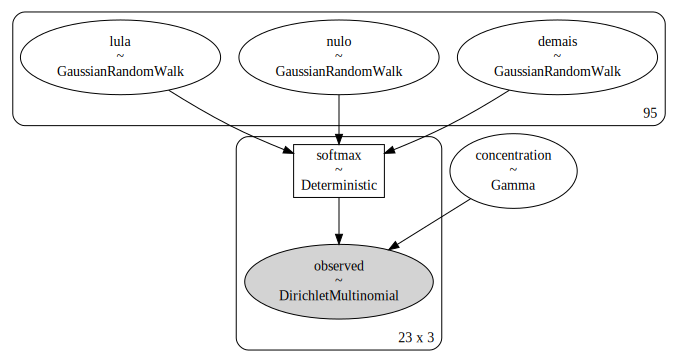

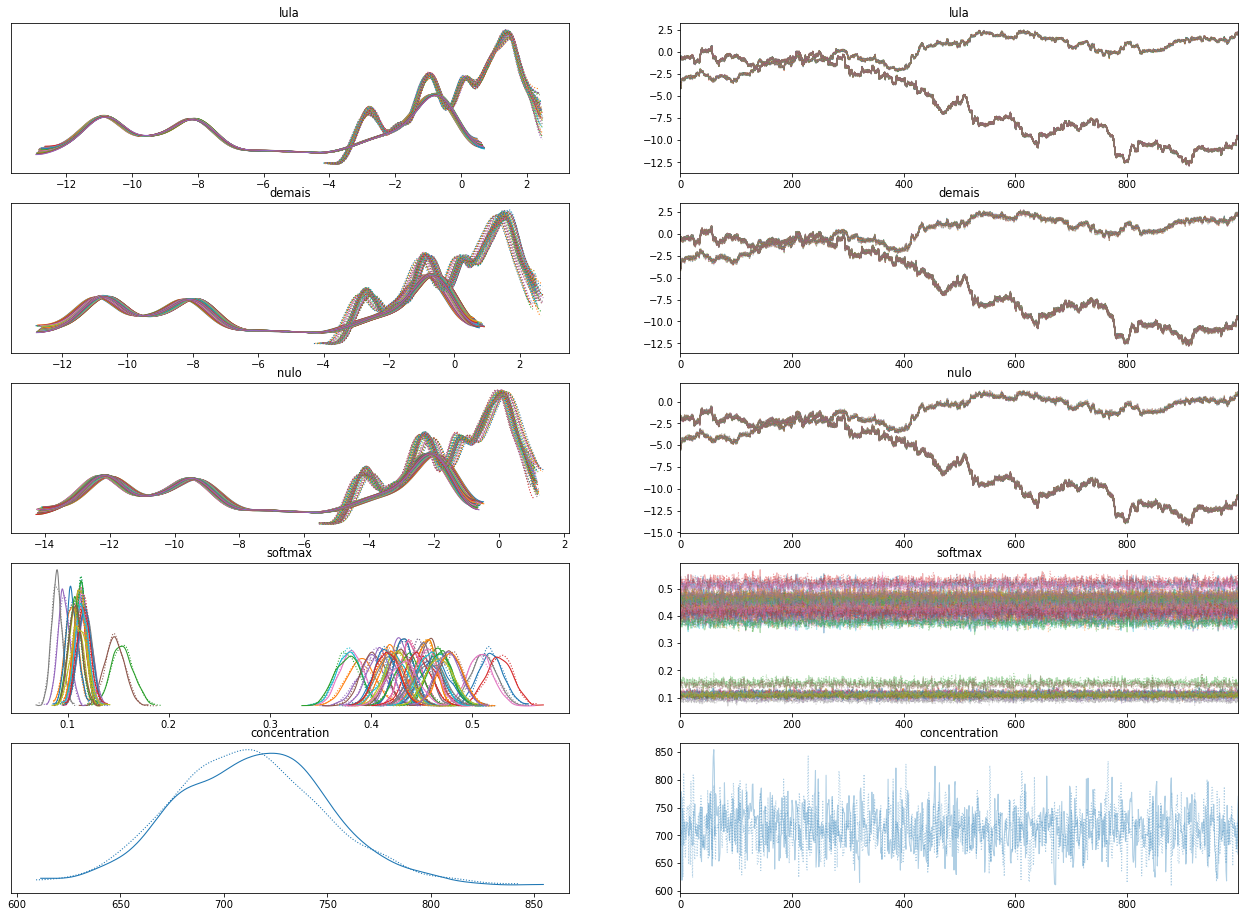

In [56]:
import theano.tensor as tt
from datetime import datetime

LULA = df.LULA.astype("int32")
OUTROS = df.OUTROS.astype("int32")
NULO = df.NULO.astype("int32")
TOTAL = LULA + OUTROS + NULO

# inov = 0.025
inov = 0.025

with pm.Model() as grw:
    
    # inov = pm.HalfNormal('inov', sigma=0.15)
    
    # alpha = pm.Normal("alpha", shape=3)
    # baseline = pm.Normal("baseline", shape=(poll_day.shape[0], 3))
    
    grw_lula = pm.GaussianRandomWalk('lula', mu=0, sd=inov, shape=n_days)
    
    grw_demais = pm.GaussianRandomWalk('demais', mu=0, sd=inov, shape=n_days)
    
    grw_nulo  = pm.GaussianRandomWalk('nulo', mu=0, sd=inov, shape=n_days)
    # grw  = pm.GaussianRandomWalk('grw', mu=0, sd=inov, shape=(n_days, 3))
    

    prob = pm.Deterministic("softmax", tt.nnet.softmax(tt.stack([grw_lula[poll_day], grw_demais[poll_day], grw_nulo[poll_day]], axis=1)))
    # prior = tt.nnet.softmax(grw[poll_day])
    
    # conc = pm.Gamma("concentration",
    #                 alpha=(1000.0 * prob),
    #                 beta=(1.0 * np.ones(3)), shape=(poll_day.shape[0], 3)
    #         )
    conc  = pm.Gamma("concentration", alpha=400, beta=0.5)
    
    pm.DirichletMultinomial('observed', n=TOTAL, a=prob * conc, observed=np.array([LULA.values, OUTROS.values, NULO.values]).T, shape=(poll_day.shape[0], 3))
    
    trace = pm.sample(1000, tune=1000, progressbar=True, return_inferencedata=True) # , chains=4, cores=2)

    summary = az.summary(trace) # used below
    az.plot_trace(trace, figsize=(22,16))  
print(datetime.now().strftime("%H:%M:%S"))
pm.model_to_graphviz(grw)

In [57]:
# summary
#print(np.array([LULA.values, OUTROS.values, NULO.values]).T)
# v = tt.nnet.softmax(tt.stack([LULA.astype("float32").values, OUTROS.astype("float32").values, NULO.astype("float32").values], axis=1)) + np.array([0.1,0.1,0.1])
# v.eval()
#trace.posterior.baseline.mean(axis=0).mean(axis=0)
# L.shape

In [58]:
# np.array([LULA.values, OUTROS.values, NULO.values]).shape
n_days

95

In [59]:
# baseline = trace.posterior.baseline.mean(axis=0)
L = trace.posterior.lula.mean(axis=0)
D = trace.posterior.demais.mean(axis=0)
N = trace.posterior.nulo.mean(axis=0)
#IL = 
#print(baseline.shape)
TT = tt.stack([L,D,N], axis=1).eval()
print(TT.shape)
probs = []
#(baseline + tt.stack([L,D,N], axis=1).eval()[:,:,0]).shape
for i in range(n_days):
    probs.append(tt.nnet.softmax( TT[:,:,i]).eval())
probs = np.array(probs)
probs.shape

(1000, 3, 95)


(95, 1000, 3)

In [60]:
probs[:,:,:].mean(axis=1)

array([[0.45563735, 0.39019406, 0.15416858],
       [0.45419824, 0.39539768, 0.15040408],
       [0.45277905, 0.40049192, 0.14672903],
       [0.44758418, 0.40888331, 0.14353251],
       [0.44223438, 0.41733288, 0.14043274],
       [0.43684797, 0.42580076, 0.13735127],
       [0.43136549, 0.4343291 , 0.13430541],
       [0.42600793, 0.44268024, 0.13131183],
       [0.42041493, 0.45138362, 0.12820146],
       [0.41489563, 0.45995756, 0.12514681],
       [0.40934395, 0.46853203, 0.12212403],
       [0.4036943 , 0.47728963, 0.11901607],
       [0.39789213, 0.48606887, 0.116039  ],
       [0.39200654, 0.49485622, 0.11313724],
       [0.38623415, 0.50336274, 0.11040311],
       [0.38022065, 0.51210488, 0.10767446],
       [0.37751014, 0.51867161, 0.10381825],
       [0.37734037, 0.5208089 , 0.10185073],
       [0.37725258, 0.52282762, 0.09991981],
       [0.37696438, 0.52490938, 0.09812623],
       [0.37669187, 0.527076  , 0.09623213],
       [0.38201757, 0.5232118 , 0.09477063],
       [0.

(3, 95, 3)


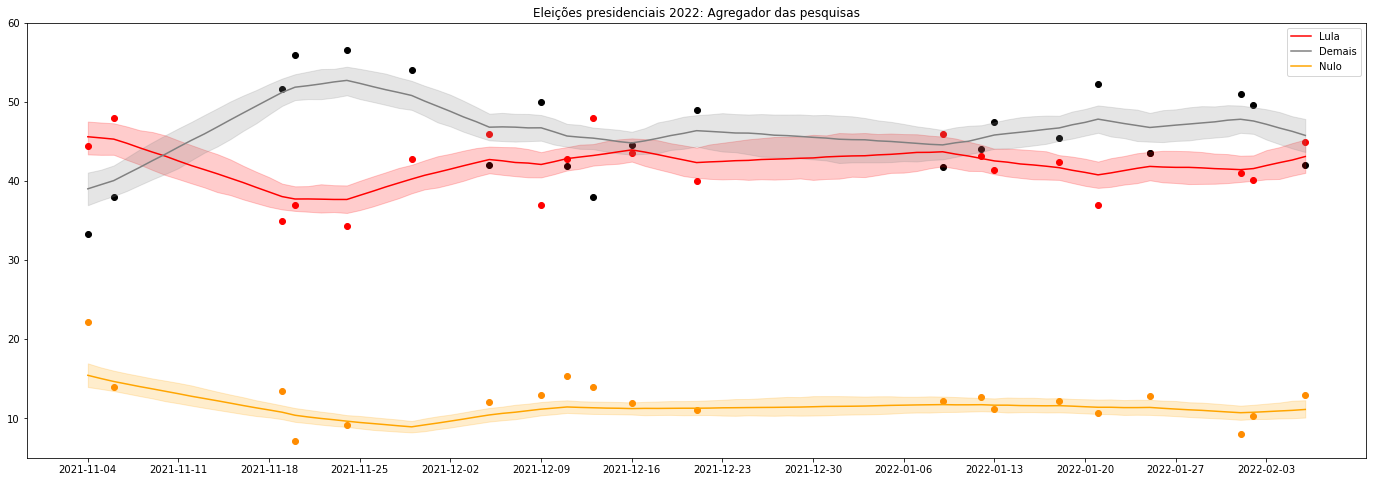

In [65]:
qs = np.quantile(probs[:,:,:], q=[0.025, 0.5, 0.975], axis=1)
print(qs.shape)
plt.figure(figsize=(24,8))
plt.ylim(5, 60)
L = np.zeros(n_days) * np.nan
O = L.copy()
N = L.copy()
L[poll_day.values] = 100.0 * df.LULA/df.TOTAL
O[poll_day.values] = 100.0 * df.OUTROS/df.TOTAL
N[poll_day.values] = 100.0 * df.NULO/df.TOTAL
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.scatter(datas, L, color='red')
plt.scatter(datas, O, color='black')
plt.scatter(datas, N, color='darkorange')
plt.plot(datas, qs[1,:,0]*100, color='red', label="Lula")
plt.plot(datas, qs[1,:,1]*100, color='gray', label="Demais")
plt.plot(datas, qs[1,:,2]*100, color='orange', label="Nulo")
plt.fill_between(x=datas, y1=qs[0,:,0]*100., y2=qs[2,:,0]*100., alpha=0.2, color='red')
plt.fill_between(x=datas, y1=qs[0,:,1]*100., y2=qs[2,:,1]*100., alpha=0.2, color='gray')
plt.fill_between(x=datas, y1=qs[0,:,2]*100., y2=qs[2,:,2]*100., alpha=0.2, color='orange')
plt.xticks([d for i,d in enumerate(datas) if i % 7 ==0]);
plt.legend(loc='best');
#plt.text(datas[-1], qs[0][-1]-.2, f'{qs[0,:,0]:.2f}%', color='red');
#plt.text(datas[-1], qsL[1][-1]-.2, f'{qsL[1][-1]:.2f}%', color='red');
#plt.text(datas[-1], qsL[2][-1]-.2, f'{qsL[2][-1]:.2f}%', color='red');


In [62]:
qs[2,:,0]*100

array([47.52324752, 47.4052552 , 47.30394629, 46.90838257, 46.43361295,
       46.19628391, 45.76483143, 45.13118292, 44.53709064, 43.95253803,
       43.40678645, 42.74152715, 41.92871713, 41.18510143, 40.49115481,
       39.67595764, 39.33406111, 39.36322172, 39.59646242, 39.47658967,
       39.44578287, 40.03230508, 40.58238959, 41.10845846, 41.65656811,
       42.05433397, 42.61873042, 43.13515856, 43.45779831, 43.84497726,
       44.17643327, 44.3603831 , 44.30190555, 44.27758536, 44.04454468,
       43.65191011, 44.0323976 , 44.2968776 , 44.60503756, 44.67073441,
       45.03766187, 45.27112634, 45.39752644, 45.30138079, 45.15983801,
       44.78681477, 44.51748405, 44.22617401, 44.62631778, 44.8393214 ,
       45.05451619, 45.27811902, 45.42400114, 45.57080028, 45.58472238,
       45.66330285, 45.84432656, 45.77529357, 46.07248878, 46.01948541,
       46.07465583, 45.94650759, 46.01168736, 45.94132425, 45.9197736 ,
       45.74566563, 45.62499335, 45.37742068, 44.97305434, 44.58

## Weekly results ploted daily

In [63]:
dfrw = df_results_weekly.groupby('data').mean().reset_index(col_level=1).copy()
dfrw.columns = dfrw.columns.to_flat_index()
# print(dfrw)
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))

plt.scatter(df.data_pesquisa, df.LULA/df.TOTAL, color='red')
plt.scatter(df.data_pesquisa, df["OUTROS"]/df["TOTAL"], color='gray')
plt.plot(dfrw.data, dfrw.LulaM, color='red', label="Lula")
plt.fill_between(x=dfrw.data, y1=dfrw.LulaLB, y2=dfrw.LulaUB, alpha=0.2, color='red')
plt.plot(dfrw.data, dfrw.DemaisM, color='gray', label="Demais")
plt.fill_between(x=dfrw.data, y1=dfrw.DemaisLB, y2=dfrw.DemaisUB, alpha=0.2, color='gray')

plt.text(dfrw.data.values[-1], dfrw.LulaUB.values[-1]-.001, f'{dfrw.LulaUB.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaM.values[-1]-.001, f'{dfrw.LulaM.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaLB.values[-1]-.001, f'{dfrw.LulaLB.values[-1] * 100:.2f}%', color='red')

plt.text(dfrw.data.values[-1], dfrw.DemaisUB.values[-1]-.001, f'{dfrw.DemaisUB.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisM.values[-1]-.001, f'{dfrw.DemaisM.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisLB.values[-1]-.001, f'{dfrw.DemaisLB.values[-1] * 100:.2f}%', color='gray')
plt.legend(loc='lower right')
plt.xticks([d for i,d in enumerate(dfrw.data.values) if i % 2 ==0]);
plt.show()

NameError: name 'df_results_weekly' is not defined

In [ ]:

blabla

NameError: name 'blabla' is not defined

### Machine Learning

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
to_dt = lambda x: pd.to_datetime(x)
day_zero = to_dt(df.data_pesquisa).min()
n_days = int((to_dt(df.data_pesquisa).max() - day_zero) / pd.Timedelta(days=1)) + 1
poll_day = ((to_dt(df.data_pesquisa) - day_zero) / pd.Timedelta(days=1)).astype(int)

In [ ]:
print(f'{day_zero=}')
print(f'{n_days=}')
print(f'{poll_day.values=}')

day_zero=Timestamp('2021-11-04 00:00:00')
n_days=90
poll_day.values=array([ 0,  2, 15, 16, 20, 25, 31, 35, 37, 39, 39, 42, 42, 47, 66, 69, 70,
       75, 78, 82, 89])


In [ ]:
svr = SVR(kernel='rbf', C=50, gamma=1e-3, epsilon=0.1)
Y = 100* df.LULA/df.TOTAL
print(poll_day.shape, Y.shape)

(21,) (21,)


In [ ]:
svr.fit(poll_day.values.reshape(-1,1), Y, sample_weight=df.TOTAL/2000.0)

SVR(C=50, gamma=0.001)

In [ ]:
pred_lula = svr.predict(np.arange(0,85).reshape(-1,1))

In [ ]:
pred_lula

array([44.34454373, 43.63773655, 42.94545908, 42.27342395, 41.6271523 ,
       41.01190004, 40.43258711, 39.89373102, 39.3993859 , 38.95308824,
       38.55781028, 38.21592187, 37.92916172, 37.69861843, 37.52472164,
       37.40724371, 37.34531152, 37.33742857, 37.38150654, 37.47490601,
       37.61448535, 37.79665681, 38.01744884, 38.27257327, 38.55749614,
       38.86751075, 39.19781161, 39.5435678 , 39.89999452, 40.26242142,
       40.62635656, 40.98754491, 41.34202049, 41.68615126, 42.01667627,
       42.33073454, 42.62588549, 42.90012081, 43.15186792, 43.37998533,
       43.58375035, 43.76283979, 43.9173043 , 44.04753739, 44.15423978,
       44.23838037, 44.3011546 , 44.34394144, 44.36825985, 44.37572575,
       44.36801052, 44.3468016 , 44.31376624, 44.27051874, 44.21859189,
       44.1594129 , 44.094284  , 44.02436805, 43.95067885, 43.87407638,
       43.79526637, 43.71480426, 43.63310277, 43.55044291, 43.46698772,
       43.38279826, 43.29785124, 43.21205767, 43.12528204, 43.03

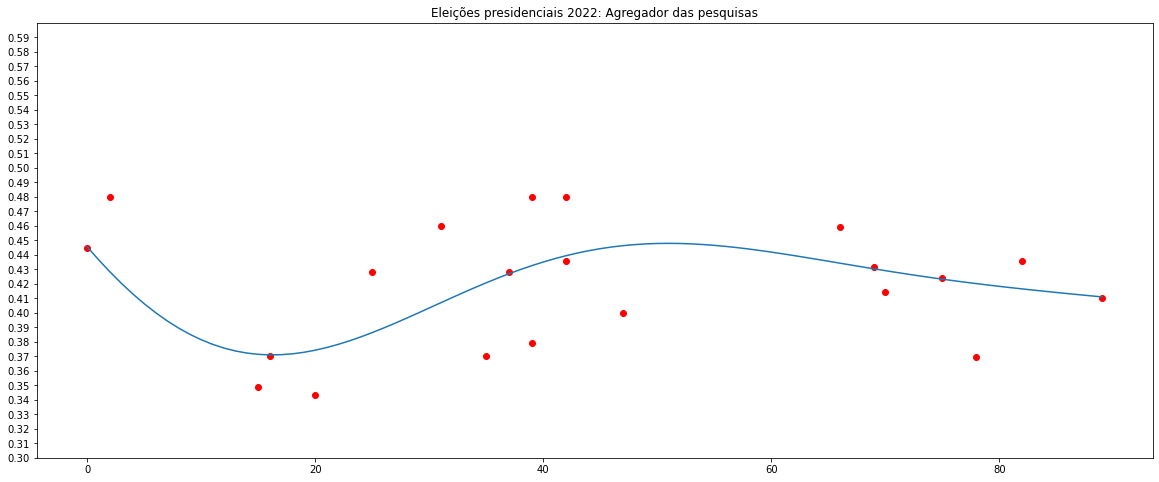

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))
plt.scatter(poll_day, df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(pred_lula.shape[0]), pred_lula/100.);

In [ ]:
from sklearn.model_selection import GridSearchCV
svr = SVR()
parameters = {'C': np.arange(500, 2000, 50), 'gamma': np.arange(1e-05, 1.1e-3, 1e-5)}

In [ ]:
clf = GridSearchCV(svr, parameters, scoring='neg_mean_squared_error', cv=poll_day.values.size//1, verbose=1)
clf.fit(poll_day.values.reshape(-1,1), Y, sample_weight=np.sqrt(df.TOTAL/df.TOTAL.min()))

Fitting 21 folds for each of 3270 candidates, totalling 68670 fits


GridSearchCV(cv=21, estimator=SVR(),
             param_grid={'C': array([ 500,  550,  600,  650,  700,  750,  800,  850,  900,  950, 1000,
       1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
       1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950]),
                         'gamma': array([1.00e-05, 2.00e-05, 3.00e-05, 4.00e-05, 5.00e-05, 6.00e-05,
       7.00e-05, 8.00e-05, 9.00e-05, 1.00e-04, 1.10e-04, 1.20e-04,
       1.30e-04, 1.40e-04, 1.50e-04,...
       7.30e-04, 7.40e-04, 7.50e-04, 7.60e-04, 7.70e-04, 7.80e-04,
       7.90e-04, 8.00e-04, 8.10e-04, 8.20e-04, 8.30e-04, 8.40e-04,
       8.50e-04, 8.60e-04, 8.70e-04, 8.80e-04, 8.90e-04, 9.00e-04,
       9.10e-04, 9.20e-04, 9.30e-04, 9.40e-04, 9.50e-04, 9.60e-04,
       9.70e-04, 9.80e-04, 9.90e-04, 1.00e-03, 1.01e-03, 1.02e-03,
       1.03e-03, 1.04e-03, 1.05e-03, 1.06e-03, 1.07e-03, 1.08e-03,
       1.09e-03])},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
clf.best_params_

{'C': 550, 'gamma': 0.00048000000000000007}

In [ ]:
np.arange(1e-3, 1e-1, 5e-3)

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026, 0.031, 0.036, 0.041,
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096])

In [ ]:
pred_lula = clf.best_estimator_.predict(np.arange(0,n_days).reshape(-1,1))

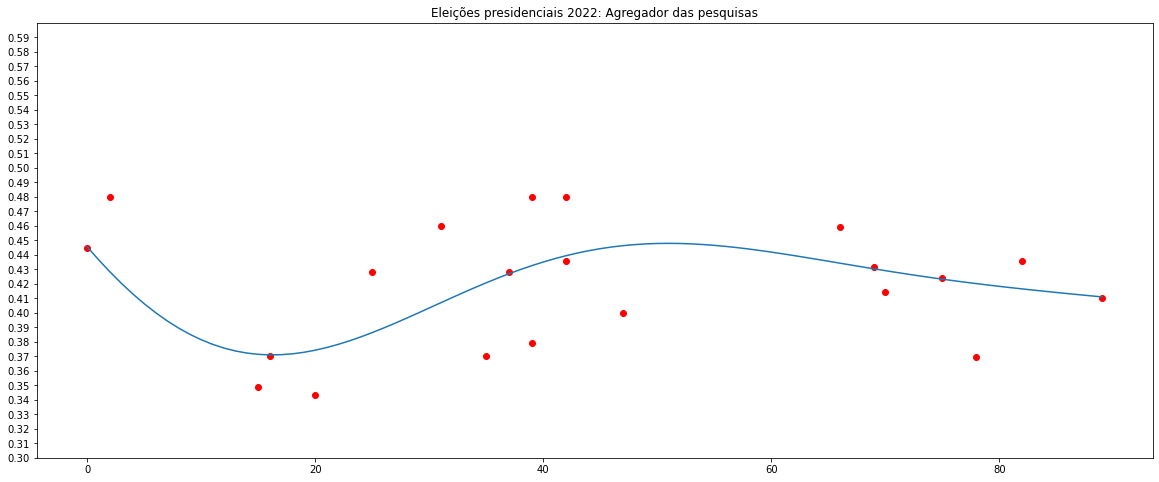

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))
plt.scatter(poll_day, df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(0,n_days), pred_lula/100.)

In [ ]:
res = []
svr = SVR(C=1600, gamma=7.000000000000001e-05)
x_pred = np.arange(0, n_days)
a = np.arange(0, poll_day.values.size)
sw = df.TOTAL/df.TOTAL.min()
for _ in range(10_000):
    idx = np.random.choice(a, size=poll_day.values.size)
    svr.fit(poll_day.iloc[idx].values.reshape(-1,1), Y.iloc[idx].values, sample_weight=sw.iloc[idx].values)
    res.append(svr.predict(x_pred.reshape(-1,1)))
res = np.array(res)
print(res.shape)

(10000, 90)


In [ ]:
qs = np.quantile(res, q=[0.025, 0.2, 0.5, 0.8, 0.975], axis=0)
qs.shape

(5, 90)

Text(89, 30.248883537318253, '30.50%')

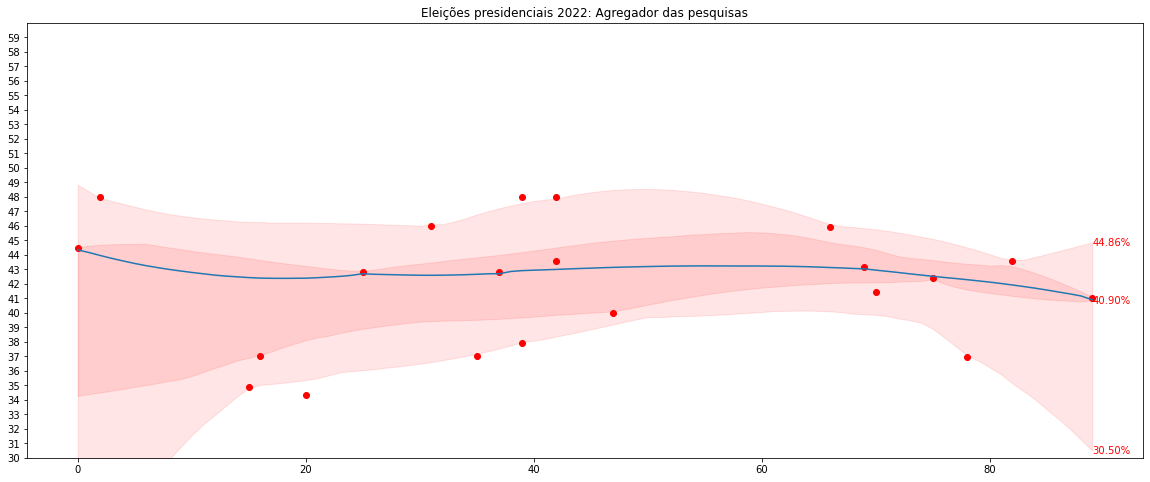

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(30, 60)
plt.yticks(np.arange(30, 60, 1))
plt.scatter(poll_day, 100*df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(0,n_days), qs[2])
plt.fill_between(x=np.arange(0,n_days), y1=qs[0], y2=qs[4], alpha=0.1, color='red')
plt.fill_between(x=np.arange(0,n_days), y1=qs[1], y2=qs[3], alpha=0.1, color='red')
plt.text(n_days-1, qs[4][-1]-.25, f'{qs[4][-1]:.2f}%', color='red')
plt.text(n_days-1, qs[2][-1]-.25, f'{qs[2][-1]:.2f}%', color='red')
plt.text(n_days-1, qs[0][-1]-.25, f'{qs[0][-1]:.2f}%', color='red')


In [ ]:
from sklearn.neural_network import MLPClassifier

res = []
rf = RandomForestClassifier(n_estimators=100)
x_pred = np.arange(0, n_days)
a = np.arange(0, poll_day.values.size)
sw = np.sqrt(df.TOTAL/df.TOTAL.min())
Y = np.array([df.LULA/df.TOTAL, df.OUTROS/df.TOTAL, df.NULO/df.TOTAL]).T
print(Y.shape)
for _ in range(10_000):
    idx = np.random.choice(a, size=poll_day.values.size)
    rf.fit(poll_day.iloc[idx].values.reshape(-1,1), Y[idx], sample_weight=sw.iloc[idx].values)
    res.append(rf.predict(x_pred.reshape(-1,1)))
res = np.array(res)
print(res.shape)

NameError: name 'RandomForestClassifier' is not defined

## Multinomial Logistic Regression with custom loss function

In [ ]:
def linear(x, betas):
    return np.dot(x, np.array(betas).reshape(x.shape[1], -1))

def multinomial(z):
    return np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True)

def costJ(X, y, theta, C, weight=None):
    m = y.shape[0]
    if weight is None:
        weight = np.repeat(1.0, m).reshape(m,1)
    else:
        weight = weight.reshape(m,1)
    res = np.abs(y - multinomial(linear(X, theta)))
    regul = np.sum(weight * C * np.sum(theta**2))
    return 1./m * (np.sum((10*res)**2) + regul)
    #return 1./m * np.sum(-np.log(1. - res + 1e-6) + regul)
    # return np.sum(-np.log(1.0 - res + 1e-6))
    

In [ ]:
x = np.hstack([np.ones((10,1)), np.ones((10,1)) * np.arange(10).reshape(10,-1)])
betas = np.random.randn(2,3)
x, betas

In [ ]:
linear(x, betas)

In [ ]:
multinomial(linear(x,betas))

In [ ]:
pred = multinomial(linear(x, betas))
costJ(x, pred+0.05, betas, 1.0, np.arange(1,11))

In [ ]:
truth = np.random.dirichlet(alpha=[440, 120, 440], size=2)
truth = truth.mean(axis=0) - (np.arange(1,11).reshape(10,1)*0.001) + np.random.randn(10,3)*0.01
truth = truth/truth.sum(axis=1).reshape(-1,1)
print(truth)

In [ ]:

opt = lambda bs: costJ(x, truth, bs, 0.05, np.arange(10,0, -1)) 
 

In [ ]:
import scipy as sp
found = False
res = sp.optimize.minimize(opt, np.random.randn(6), method='BFGS', options={'gtol': 1e-6})
print(res.success)


In [ ]:
computed_betas = res.x

In [ ]:
multinomial(linear(x, computed_betas))

In [ ]:
truth